# CUSTOMER SPENDING PREDICTION

La necesidad de prever y optimizar el gasto de sus usuarios ha llevado a una empresa de comercio electrónico a buscar soluciones innovadoras. Como científicos de datos, hemos sido convocados para desarrollar un modelo de machine learning que pueda predecir con precisión cuánto gastará un usuario al visitar dicho sitio web.

## 1. IMPORTANDO LIBRERÍAS Y DATASET 

In [1]:
!pip install wget
!pip install xgboost
!pip install lightgbm

In [2]:
## Importando las librerías a utilizar
import wget
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import FunctionTransformer
from joblib import dump, load

In [3]:
## Cargando el dataset a trabajar
df_traffic = pd.read_csv('traffic_site.csv')
df_traffic.head(6)

,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",9674781571160116268,"{""continent"": ""Asia"", ""subContinent"": ""Southea...",9674781571160116268_1472804607,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472804607,1,1472804607
1,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",8590648239310839049,"{""continent"": ""Europe"", ""subContinent"": ""Easte...",8590648239310839049_1472835928,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472835928,1,1472835928
2,Affiliates,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",9772828344252850532,"{""continent"": ""Americas"", ""subContinent"": ""Sou...",9772828344252850532_1472856802,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""Data Share Promo"", ""source"": ""Pa...",1472856802,1,1472856802
3,Organic Search,20160902,"{""browser"": ""Safari"", ""browserVersion"": ""not a...",1350700416054916432,"{""continent"": ""Americas"", ""subContinent"": ""Nor...",1350700416054916432_1472879649,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472879649,2,1472879649
4,Organic Search,20160902,"{""browser"": ""Safari"", ""browserVersion"": ""not a...",1350700416054916432,"{""continent"": ""Americas"", ""subContinent"": ""Nor...",1350700416054916432_1472829671,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""5"", ""pageviews"": ""4"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472829671,1,1472829671
5,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",9874029322760071744,"{""continent"": ""Americas"", ""subContinent"": ""Sou...",9874029322760071744_1472825224,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""7"", ""pageviews"": ""5"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472825224,1,1472825224


**OBSERVACIÓN INICIAL**
* Observamos que tenemos 4 columnas que poseen cadenas de texto, que representan a diccionarios en formato JSON
* Estas columnas **'device','geoNetwork','totals','trafficSource'**, continen dentro del diccionario varios tipos de información que será necesario recopilar.

In [4]:
df_traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12283 entries, 0 to 12282
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   channelGrouping       12283 non-null  object
 1   date                  12283 non-null  int64 
 2   device                12283 non-null  object
 3   fullVisitorId         12283 non-null  uint64
 4   geoNetwork            12283 non-null  object
 5   sessionId             12283 non-null  object
 6   socialEngagementType  12283 non-null  object
 7   totals                12283 non-null  object
 8   trafficSource         12283 non-null  object
 9   visitId               12283 non-null  int64 
 10  visitNumber           12283 non-null  int64 
 11  visitStartTime        12283 non-null  int64 
dtypes: int64(4), object(7), uint64(1)
memory usage: 1.1+ MB


* Notamos que tenemos 12 columnas y 12283 filas en nuestro dataset
* Validamos que no tenemos presencia de datos nulos, se analizará posteriormente
* Tenemos dos tipos de datos: integer y object
* Notamos que algunos tipos de datos no son correspondientes con algunas variables, como la variable **date**, se trabajará posteriormente.

## 2. PREPROCESAMIENTO DE DATOS 

* Iniciamos separando las columnas que trabajaremos, ya que estas columnas poseen diccionarios con más variables en su interior, para cada fila.

In [5]:
## Separando las columnas que poseen cadenas de texto que representan diccionarios
diccionarios = ['device','geoNetwork','totals','trafficSource']

### 2.1 ANALIZANDO LA COLUMNA 'device'

* Esta sección contiene información sobre los dispositivos de usuario.

In [6]:
## Transformando las llaves de los diccionarios en nuevas columnas de nuestro dataframe
df_device = pd.DataFrame()
for i in df_traffic[diccionarios[0]]:    
    # Crear DataFrame temporal a partir del diccionario
    df_temp = pd.DataFrame([json.loads(i)])
    # Concatenar el DataFrame temporal al DataFrame principal
    df_device = pd.concat([df_device, df_temp], ignore_index=True)

df_device.head(10)

,browser,browserVersion,browserSize,operatingSystem,operatingSystemVersion,isMobile,mobileDeviceBranding,mobileDeviceModel,mobileInputSelector,mobileDeviceInfo,mobileDeviceMarketingName,flashVersion,language,screenColors,screenResolution,deviceCategory
0,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop
1,Chrome,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop
2,Chrome,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop
3,Safari,not available in demo dataset,not available in demo dataset,iOS,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,mobile
4,Safari,not available in demo dataset,not available in demo dataset,iOS,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,mobile
5,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop
6,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop
7,Chrome,not available in demo dataset,not available in demo dataset,Android,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,tablet
8,Safari,not available in demo dataset,not available in demo dataset,iOS,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,mobile
9,Firefox,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not availa

In [7]:
## Validamos que nuestras nuevas columnas generadas, tengan diferentes categorias para cada variable generada
dict_device = {}
for i in df_device.columns:
    dict_device[i] = len(df_device[i].unique())
df_count = pd.DataFrame([dict_device]).T.reset_index()
df_count.columns = ['Variable','valores']
df_count_sorted = df_count.sort_values(by = 'valores', ascending=False).reset_index(drop=True)
df_count_sorted

,Variable,valores
0,browser,22
1,operatingSystem,12
2,deviceCategory,3
3,isMobile,2
4,browserVersion,1
5,browserSize,1
6,operatingSystemVersion,1
7,mobileDeviceBranding,1
8,mobileDeviceModel,1
9,mobileInputSelector,1


* Validamos que solo las 4 columnas que poseen varias categorias en las variables nos presentan valor para nuestros posteriores análisis.
* Se observa que las columnas que tienen solo 1 categoría para cada variable, tienen la nomenclatura de **'not available in demo dataset'**, lo cual no nos aporta valor.
* Debido a esto se decide solo continuar con las 4 columnas que poseen varias categorias y nos aportan valor, las demás se eliminaran.

In [8]:
## Mi nuevo dataframe para esta variable quedaría de la siguiente forma
df_device = df_device[df_count_sorted['Variable'][0:4]]
df_device

,browser,operatingSystem,deviceCategory,isMobile
0,Chrome,Windows,desktop,False
1,Chrome,Macintosh,desktop,False
2,Chrome,Macintosh,desktop,False
3,Safari,iOS,mobile,True
4,Safari,iOS,mobile,True
...,...,...,...,...
12278,Chrome,Windows,desktop,False
12279,Chrome,Android,mobile,True
12280,Chrome,Linux,desktop,False
12281,Chrome,Android,mobile,True


**DICCIONARIO - SIGNIFICADO COLUMNAS :**
https://support.google.com/analytics/answer/3437719?hl=es-419

* Al observar este dataframe y basandonos en el diccionario de las columnas mostrado en el Link superior, podemos concluir que ciertas columnas no serian relevantes para nuestro objetivo que es predecir cuanto gastará un usuario al visitar dicho sitio web.
* La columna **'browser'**, al solo ser el navegador utilizado, nos resulta que no aporta el valor como para influir en nuestro objetivo.
* Asimismo, la variable **operatingSystem**, al ser solo el sistema operativo considermos que no aportaría valor a la hora de predecir cuanto gastará un usuario al visitar la página web.
* Por el contrario, las variables **deviceCategory** y **isMobile**, consideramos que si podrían influir debido a la experiencia de usuario al navegar por diferente tipos de dispositivos, eso influye en las emociones de las personas.
* Debido a eso, solo nos quedaríamos con las variables que consideramos influyentes para nuestro objetivo.

### 2.1.1 NUEVO DATAFRAME 'device'

In [9]:
## Eliminado columnas que no son relevantes
df_device = df_device[['deviceCategory','isMobile']]
df_device

,deviceCategory,isMobile
0,desktop,False
1,desktop,False
2,desktop,False
3,mobile,True
4,mobile,True
...,...,...
12278,desktop,False
12279,mobile,True
12280,desktop,False
12281,mobile,True


### 2.2 ANALIZANDO LA COLUMNA 'geoNetwork'

* Esta sección contiene información sobre la ubicación geográfica del usuario.

In [10]:
## Transformando las llaves de los diccionarios en nuevas columnas de nuestro dataframe
df_geoNetwork = pd.DataFrame()
for i in df_traffic[diccionarios[1]]:    
    # Crear DataFrame temporal a partir del diccionario
    df_temp = pd.DataFrame([json.loads(i)])
    # Concatenar el DataFrame temporal al DataFrame principal
    df_geoNetwork = pd.concat([df_geoNetwork, df_temp], ignore_index=True)

df_geoNetwork.head(10)

,continent,subContinent,country,region,metro,city,cityId,networkDomain,latitude,longitude,networkLocation
0,Asia,Southeast Asia,Singapore,(not set),(not set),Singapore,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset
1,Europe,Eastern Europe,Poland,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,tpnet.pl,not available in demo dataset,not available in demo dataset,not available in demo dataset
2,Americas,South America,Argentina,Buenos Aires,(not set),Buenos Aires,not available in demo dataset,phonevision.com.ar,not available in demo dataset,not available in demo dataset,not available in demo dataset
3,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,comcast.net,not available in demo dataset,not available in demo dataset,not available in demo dataset
4,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,att.net,not available in demo dataset,not available in demo dataset,not available in demo dataset
5,Americas,South America,Argentina,Buenos Aires,(not set),Buenos Aires,not available in demo dataset,phonevision.com.ar,not available in demo dataset,not available in demo dataset,not available in demo dataset
6,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,cox.net,not available in demo dataset,not available in demo dataset,not available in demo dataset
7,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,level3.net,not available in demo dataset,not available in demo dataset,not available in demo dataset
8,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,comcast.net,not available in demo dataset,not available in demo dataset,not available in demo dataset
9,Europe,Southern Europe,Italy,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,teletu.it,not available in demo dataset,not available in demo dataset,not available in demo dataset


In [11]:
## Validamos que nuestras nuevas columnas generadas, tengan diferentes categorias para cada variable generada
dict_geoNetwork = {}
for i in df_geoNetwork.columns:
    dict_geoNetwork[i] = len(df_geoNetwork[i].unique())
df_count = pd.DataFrame([dict_geoNetwork]).T.reset_index()
df_count.columns = ['Variable','valores']
df_count_sorted = df_count.sort_values(by = 'valores', ascending=False).reset_index(drop=True)
df_count_sorted

,Variable,valores
0,networkDomain,1747
1,city,296
2,region,212
3,country,145
4,metro,53
5,subContinent,22
6,continent,6
7,cityId,1
8,latitude,1
9,longitude,1


* En primera instancia, validamos que las 7 columnas que poseen varias categorias en las variables nos representan valor para nuestros análisis.
* Se observa que las columnas que tienen solo 1 categoría para cada variable, tienen la nomenclatura de **'not available in demo dataset'**, lo cual no nos aporta valor.
* Debido a esto se decide solo continuar con las 7 columnas que poseen varias categorias y nos aportan valor, las demás se eliminaran.

In [12]:
## Mi nuevo dataframe para esta variable quedaría de la siguiente forma
df_geoNetwork = df_geoNetwork[df_count_sorted['Variable'][0:7]]
df_geoNetwork

,networkDomain,city,region,country,metro,subContinent,continent
0,unknown.unknown,Singapore,(not set),Singapore,(not set),Southeast Asia,Asia
1,tpnet.pl,not available in demo dataset,not available in demo dataset,Poland,not available in demo dataset,Eastern Europe,Europe
2,phonevision.com.ar,Buenos Aires,Buenos Aires,Argentina,(not set),South America,Americas
3,comcast.net,not available in demo dataset,not available in demo dataset,United States,not available in demo dataset,Northern America,Americas
4,att.net,not available in demo dataset,not available in demo dataset,United States,not available in demo dataset,Northern America,Americas
...,...,...,...,...,...,...,...
12278,unknown.unknown,not available in demo dataset,not available in demo dataset,Poland,not available in demo dataset,Eastern Europe,Europe
12279,vodafone-ip.de,not available in demo dataset,not available in demo dataset,Germany,not available in demo dataset,Western Europe,Europe
12280,(not set),not available in demo dataset,not available in demo dataset,India,not available in demo dataset,Southern Asia,Asia
12281,cgates.lt,not available in demo dataset,not available in demo dataset,Lithuania,not available in demo dataset,Northern Europe,Europe


**DICCIONARIO - SIGNIFICADO COLUMNAS :**
https://support.google.com/analytics/answer/3437719?hl=es-419

* Al observar este dataframe y basandonos en el diccionario de las columnas mostrado en el Link superior, podemos concluir que ciertas columnas no serian relevantes para nuestro objetivo que es predecir cuanto gastará un usuario al visitar dicho sitio web.
* La columna **'networkDomain'**, al solo ser el dominio de la red, nos resulta que no aporta el valor como para influir en nuestro objetivo.
* Vemos que hay columnas de ubicación, como lo son el **continent, subcontinent, country, región y city**. De todas estas, y despues de analizar en el diccionario, y viendo que **city** tiene más variedad de subcategorías, decidimos solo quedarnos con esta variable, ya que consideramos que esta variable ya abarca lo necesario para entender la ubicación de los usuarios.
* Asimismo, la variable **metro**, la consideramos de relevancia ya que nos representa el área de mercado designada desde la que se originan las sesiones, y no la podemos eliminar en primera instancia.

### 2.2.1 DATAFRAME FINAL  'geoNetwork'

In [13]:
## Eliminando columnas que no son relevantes
df_geoNetwork = df_geoNetwork[['city','metro']]
df_geoNetwork

,city,metro
0,Singapore,(not set)
1,not available in demo dataset,not available in demo dataset
2,Buenos Aires,(not set)
3,not available in demo dataset,not available in demo dataset
4,not available in demo dataset,not available in demo dataset
...,...,...
12278,not available in demo dataset,not available in demo dataset
12279,not available in demo dataset,not available in demo dataset
12280,not available in demo dataset,not available in demo dataset
12281,not available in demo dataset,not available in demo dataset


### 2.3 ANALIZANDO LA COLUMNA 'totals'

* Esta sección contiene valores globales de la sesión.

In [14]:
## Transformando las llaves de los diccionarios en nuevas columnas de nuestro dataframe
df_totals = pd.DataFrame()
for i in df_traffic[diccionarios[2]]:    
    # Crear DataFrame temporal a partir del diccionario
    df_temp = pd.DataFrame([json.loads(i)])
    # Concatenar el DataFrame temporal al DataFrame principal
    df_totals = pd.concat([df_totals, df_temp], ignore_index=True)

df_totals.head(10)

,visits,hits,pageviews,bounces,newVisits,transactionRevenue
0,1,1,1,1,1,NaN
1,1,1,1,1,1,NaN
2,1,1,1,1,1,NaN
3,1,1,1,1,NaN,NaN
4,1,5,4,NaN,1,NaN
5,1,7,5,NaN,1,NaN
6,1,19,15,NaN,NaN,NaN
7,1,27,19,NaN,1,NaN
8,1,49,32,NaN,NaN,NaN
9,1,1,1,1,1,NaN


In [15]:
## Validamos que nuestras nuevas columnas generadas, tengan diferentes categorias para cada variable generada
dict_totals = {}
for i in df_totals.columns:
    dict_totals[i] = len(df_totals[i].unique())
df_count = pd.DataFrame([dict_totals]).T.reset_index()
df_count.columns = ['Variable','valores']
df_count_sorted = df_count.sort_values(by = 'valores', ascending=False).reset_index(drop=True)
df_count_sorted

,Variable,valores
0,transactionRevenue,147
1,hits,96
2,pageviews,75
3,bounces,2
4,newVisits,2
5,visits,1


In [16]:
## Validando datos nulos en el dataframe
df_totals.isnull().sum()

visits                    0
hits                      0
pageviews                 0
bounces                6111
newVisits              2838
transactionRevenue    12119
dtype: int64

**DICCIONARIO - SIGNIFICADO COLUMNAS :**
https://support.google.com/analytics/answer/3437719?hl=es-419

* Observamos que solo existe una variable -**visit**- con un valor de categoria, el resto de variables si tienen varias categorías. La variable **visit** al ser un parámetro que nos indica que la sesión ha tenido interacción o no, consideramos que es relevante para nuestro objetivo, ya que es necesario que haya interacción para que el usuario consuma. Sin embargo, también notamos que solo existe un valor, que siempre ha habido interacción, debido a esto en términos generales no nos aportaría el valor suficiente. Se decide eliminarla.
* Las variables **bounces** y **newVisits**, adoptan valores binarios de 0 y 1, y son relevantes para nuestro objetivo que es determinar el consumo al visitar la pagina web, ya que si no visita la página o no hay rebote en la página, no podríamos deducir que está navegando por la página. Notamos que si bien el valor 1 si figura en el dataframe, el valor 0 no figura, por el contrario esta representado por **NaN**. Esto es cotejado con la cantidad de valores presentes en la columna, solo existen 2. En este caso tenemos que imputar estos valores **NaN** con valor 0.
* Ahora, la variable **transactionRevenue**, nos indica ingresos totales de la transacción, en este caso, esta variable sería nuestra **variable objetivo**. Pero notamos que existen valores **NaN**, estos son generados cuando el usuario no realiza consumo, en teoría estos valores son 0, por eso también los imputariamos.
* Por otro lado, las variables **hits** y **pageviews**, por lo que significan en la definición que poseemos, las consideramos muy importantes para nuestros análisis.
* Es así que decidimos solo quedarnos con las siguientes variables: **hits, pageviews, bounces, newVisits y transactionRevenue**

### 2.3.1 IMPUTANDO LOS VALORES NAN A CERO

In [17]:
## ImputaNDO los valores NaN a cero
df_totals.fillna(0, inplace=True)
df_totals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12283 entries, 0 to 12282
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   visits              12283 non-null  object
 1   hits                12283 non-null  object
 2   pageviews           12283 non-null  object
 3   bounces             12283 non-null  object
 4   newVisits           12283 non-null  object
 5   transactionRevenue  12283 non-null  object
dtypes: object(6)
memory usage: 575.9+ KB


* Podemos observar que ya no tenemos presencia de valores nulos en nuestro dataframe.
* Sin embargo, también notamos que si bien estas variables nos representan valores numéricos, el tipo de dato que nos figura es object.
* En este caso, decidimos convertir los valores en formato int64.

### 2.3.2 TRANSFORMANDO LOS DATOS EN INT64 

In [18]:
df_totals = df_totals.apply(lambda x : pd.to_numeric(x))
df_totals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12283 entries, 0 to 12282
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   visits              12283 non-null  int64
 1   hits                12283 non-null  int64
 2   pageviews           12283 non-null  int64
 3   bounces             12283 non-null  int64
 4   newVisits           12283 non-null  int64
 5   transactionRevenue  12283 non-null  int64
dtypes: int64(6)
memory usage: 575.9 KB


### 2.3.3 DATAFRAME FINAL 'totals' 

In [19]:
## Eliminando columnas que no son relevantes
df_totals = df_totals.drop(columns='visits')
df_totals

,hits,pageviews,bounces,newVisits,transactionRevenue
0,1,1,1,1,0
1,1,1,1,1,0
2,1,1,1,1,0
3,1,1,1,0,0
4,5,4,0,1,0
...,...,...,...,...,...
12278,1,1,1,1,0
12279,1,1,1,1,0
12280,1,1,1,1,0
12281,2,2,0,0,0


### 2.4 ANALIZANDO LA COLUMNA 'trafficSource'

* Esta sección contiene información sobre la fuente de tráfico desde la que se ha generado la sesión.

In [20]:
## Transformando las llaves de los diccionarios en nuevas columnas de nuestro dataframe
df_trafficSource = pd.DataFrame()
for i in df_traffic[diccionarios[3]]:    
    # Crear DataFrame temporal a partir del diccionario
    df_temp = pd.DataFrame([json.loads(i)])
    # Concatenar el DataFrame temporal al DataFrame principal
    df_trafficSource = pd.concat([df_trafficSource, df_temp], ignore_index=True)

df_trafficSource.head(10)

,campaign,source,medium,keyword,adwordsClickInfo,isTrueDirect,referralPath,adContent,campaignCode
0,(not set),google,organic,(not provided),{'criteriaParameters': 'not available in demo ...,NaN,NaN,NaN,NaN
1,(not set),google,organic,(not provided),{'criteriaParameters': 'not available in demo ...,NaN,NaN,NaN,NaN
2,Data Share Promo,Partners,affiliate,NaN,{'criteriaParameters': 'not available in demo ...,NaN,NaN,NaN,NaN
3,(not set),google,organic,(not provided),{'criteriaParameters': 'not available in demo ...,True,NaN,NaN,NaN
4,(not set),google,organic,(not provided),{'criteriaParameters': 'not available in demo ...,NaN,NaN,NaN,NaN
5,(not set),google,organic,(not provided),{'criteriaParameters': 'not available in demo ...,NaN,NaN,NaN,NaN
6,(not set),google,organic,(not provided),{'criteriaParameters': 'not available in demo ...,True,NaN,NaN,NaN
7,(not set),(direct),(none),NaN,{'criteriaParameters': 'not available in demo ...,True,NaN,NaN,NaN
8,(not set),google,organic,(not provided),{'criteriaParameters': 'not available in demo ...,True,NaN,NaN,NaN
9,(not set),youtube.com,referral,NaN,{'criteriaParameters': 'not available in demo ...,NaN,/yt/about/it/,NaN,NaN


In [21]:
## Se observa el diccionario interno dentro de la columna 'trafficSource'
df_trafficSource['adwordsClickInfo']

0        {'criteriaParameters': 'not available in demo ...
1        {'criteriaParameters': 'not available in demo ...
2        {'criteriaParameters': 'not available in demo ...
3        {'criteriaParameters': 'not available in demo ...
4        {'criteriaParameters': 'not available in demo ...
                               ...                        
12278    {'criteriaParameters': 'not available in demo ...
12279    {'criteriaParameters': 'not available in demo ...
12280    {'criteriaParameters': 'not available in demo ...
12281    {'criteriaParameters': 'not available in demo ...
12282    {'criteriaParameters': 'not available in demo ...
Name: adwordsClickInfo, Length: 12283, dtype: object

* Se observa que los diccionarios internos en esta variable son de la misma forma y no nos aporta valor. Se decide eliminar esta columna.

In [22]:
## Eliminando la columna 'adwordsClickInfo'
df_trafficSource = df_trafficSource.drop(columns = 'adwordsClickInfo')
df_trafficSource

,campaign,source,medium,keyword,isTrueDirect,referralPath,adContent,campaignCode
0,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN
1,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN
2,Data Share Promo,Partners,affiliate,NaN,NaN,NaN,NaN,NaN
3,(not set),google,organic,(not provided),True,NaN,NaN,NaN
4,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
12278,(not set),youtube.com,referral,NaN,NaN,/yt/about/pl/,NaN,NaN
12279,(not set),youtube.com,referral,NaN,NaN,/yt/about/,NaN,NaN
12280,(not set),youtube.com,referral,NaN,NaN,/yt/about/,NaN,NaN
12281,(not set),youtube.com,referral,NaN,True,/yt/about/lt/,NaN,NaN


In [23]:
## Validamos que nuestras nuevas columnas generadas, tengan diferentes categorias para cada variable generada
dict_trafficSource = {}
for i in df_trafficSource.columns:
    dict_trafficSource[i] = len(df_trafficSource[i].unique())
df_count = pd.DataFrame([dict_trafficSource]).T.reset_index()
df_count.columns = ['Variable','valores']
df_count_sorted = df_count.sort_values(by = 'valores', ascending=False).reset_index(drop=True)
df_count_sorted

,Variable,valores
0,referralPath,198
1,keyword,129
2,source,76
3,adContent,16
4,campaign,7
5,medium,7
6,isTrueDirect,2
7,campaignCode,2


In [24]:
## Visualizando los valores nulos en el dataframe
df_trafficSource.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12283 entries, 0 to 12282
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   campaign      12283 non-null  object
 1   source        12283 non-null  object
 2   medium        12283 non-null  object
 3   keyword       5394 non-null   object
 4   isTrueDirect  3885 non-null   object
 5   referralPath  4490 non-null   object
 6   adContent     146 non-null    object
 7   campaignCode  1 non-null      object
dtypes: object(8)
memory usage: 767.8+ KB


**DICCIONARIO - SIGNIFICADO COLUMNAS :**
https://support.google.com/analytics/answer/3437719?hl=es-419

* Observamos que tres variables no tienen datos nulos y además tienen varias categorias. Estas columnas son **'campaign', 'source' y 'medium'**, las cuales consideramos que si tendrán valor a nuestro modelo, decidimos continuar con ellos.
* Las variables **'campaignCode' y 'adContent'**, tienen muchos datos nulos, debido a esto no generan demasiado valor al modelo. Decidimos prescindir de estas variables.
* La variable **'isTrueDirect'**, es un dato booleano. Notamos que si bien figura como que tuviera muchos datos nulos, estos simplemente son el valor **FALSE**, y consideramos que puede ser relevante debido a que si un usuario ingresa directamente el Link de la página web, esto nos indica que está interesado en quizás consumir. Mantendrémos esta variable.
* La variable **'keyword'**, nos da cierta referencia como la variable **'isTrueDirect'**, pero está tiene varias subcategorias y contiene también varios nulos, decidimos prescindir de está variable.
* De la misma forma **'referralPath'**, al fungir como referencia y nos da el nombre de host, consideramos que no aportaría tanto valor como si lo haría el **'isTrueDirect'**. Además tiene varias subcategorias que podrían no ayudar mucho con el modelo. Descidimos prescindir de esta variable.
* Es así que decidimos solo quedarnos con las siguientes variables: **campaign, source, medium y isTrueDirect**

In [25]:
## nuevo dataframe con las columnas seleccionadas
df_trafficSource = df_trafficSource[['campaign','source','medium','isTrueDirect']]
df_trafficSource

,campaign,source,medium,isTrueDirect
0,(not set),google,organic,NaN
1,(not set),google,organic,NaN
2,Data Share Promo,Partners,affiliate,NaN
3,(not set),google,organic,True
4,(not set),google,organic,NaN
...,...,...,...,...
12278,(not set),youtube.com,referral,NaN
12279,(not set),youtube.com,referral,NaN
12280,(not set),youtube.com,referral,NaN
12281,(not set),youtube.com,referral,True


In [26]:
## Visualizando nuevamente los valores nulos
df_trafficSource.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12283 entries, 0 to 12282
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   campaign      12283 non-null  object
 1   source        12283 non-null  object
 2   medium        12283 non-null  object
 3   isTrueDirect  3885 non-null   object
dtypes: object(4)
memory usage: 384.0+ KB


### 2.4.1 IMPUTANDO LOS VALORES NAN A FALSE

In [27]:
df_trafficSource['isTrueDirect'].fillna(False, inplace=True)
df_trafficSource.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12283 entries, 0 to 12282
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   campaign      12283 non-null  object
 1   source        12283 non-null  object
 2   medium        12283 non-null  object
 3   isTrueDirect  12283 non-null  bool  
dtypes: bool(1), object(3)
memory usage: 300.0+ KB


### 2.4.2 DATAFRAME FINAL  'trafficSource'

In [28]:
## Validando el nuevo dataframe
df_trafficSource.head(10)

,campaign,source,medium,isTrueDirect
0,(not set),google,organic,False
1,(not set),google,organic,False
2,Data Share Promo,Partners,affiliate,False
3,(not set),google,organic,True
4,(not set),google,organic,False
5,(not set),google,organic,False
6,(not set),google,organic,True
7,(not set),(direct),(none),True
8,(not set),google,organic,True
9,(not set),youtube.com,referral,False


### 2.5 UNIENDO LOS DATAFRAMES EN UNO SOLO

In [29]:
## Generando una copia del dataframe original
df_traffic_final = df_traffic.copy()
df_traffic_final

,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",9674781571160116268,"{""continent"": ""Asia"", ""subContinent"": ""Southea...",9674781571160116268_1472804607,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472804607,1,1472804607
1,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",8590648239310839049,"{""continent"": ""Europe"", ""subContinent"": ""Easte...",8590648239310839049_1472835928,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472835928,1,1472835928
2,Affiliates,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",9772828344252850532,"{""continent"": ""Americas"", ""subContinent"": ""Sou...",9772828344252850532_1472856802,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""Data Share Promo"", ""source"": ""Pa...",1472856802,1,1472856802
3,Organic Search,20160902,"{""browser"": ""Safari"", ""browserVersion"": ""not a...",1350700416054916432,"{""continent"": ""Americas"", ""subContinent"": ""Nor...",1350700416054916432_1472879649,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472879649,2,1472879649
4,Organic Search,20160902,"{""browser"": ""Safari"", ""browserVersion"": ""not a...",1350700416054916432,"{""continent"": ""Americas"", ""subContinent"": ""Nor...",1350700416054916432_1472829671,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""5"", ""pageviews"": ""4"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472829671,1,1472829671
...,...,...,...,...,...,...,...,...,...,...,...,...
12278,Social,20170104,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",7330357551242339916,"{""continent"": ""Europe"", ""subContinent"": ""Easte...",7330357551242339916_1483540608,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""referralPath"": ""/yt/about/pl/"", ""campaign"": ...",1483540608,1,1483540608
12279,Social,20170104,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",696320405243257438,"{""continent"": ""Europe"", ""subContinent"": ""Weste...",0696320405243257438_1483580407,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""referralPath"": ""/yt/about/"", ""campaign"": ""(n...",1483580407,1,1483580407
12280,Social,20170104,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",5437703324867866371,"{""continent"": ""Asia"", ""subContinent"": ""Souther...",5437703324867866371_1483592122,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""referralPath"": ""/yt/about/"", ""campaign"": ""(n...",1483592122,1,1483592122
12281,Social,20170104,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",8869363093179043393,"{""continent"": ""Europe"", ""subContinent"": ""North...",8869363093179043393_1483601927,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2""}","{""referralPath"": ""/yt/about/lt/"", ""campaign"": ...",1483601927,2,1483601927


In [30]:
# Concatenar los DataFrames horizontalmente
df_traffic_final = pd.concat([df_traffic_final, df_device, df_geoNetwork, df_totals, df_trafficSource], axis=1)
df_traffic_final.head(10)

,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime,deviceCategory,isMobile,city,metro,hits,pageviews,bounces,newVisits,transactionRevenue,campaign,source,medium,isTrueDirect
0,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",9674781571160116268,"{""continent"": ""Asia"", ""subContinent"": ""Southea...",9674781571160116268_1472804607,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472804607,1,1472804607,desktop,False,Singapore,(not set),1,1,1,1,0,(not set),google,organic,False
1,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",8590648239310839049,"{""continent"": ""Europe"", ""subContinent"": ""Easte...",8590648239310839049_1472835928,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472835928,1,1472835928,desktop,False,not available in demo dataset,not available in demo dataset,1,1,1,1,0,(not set),google,organic,False
2,Affiliates,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",9772828344252850532,"{""continent"": ""Americas"", ""subContinent"": ""Sou...",9772828344252850532_1472856802,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""Data Share Promo"", ""source"": ""Pa...",1472856802,1,1472856802,desktop,False,Buenos Aires,(not set),1,1,1,1,0,Data Share Promo,Partners,affiliate,False
3,Organic Search,20160902,"{""browser"": ""Safari"", ""browserVersion"": ""not a...",1350700416054916432,"{""continent"": ""Americas"", ""subContinent"": ""Nor...",1350700416054916432_1472879649,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472879649,2,1472879649,mobile,True,not available in demo dataset,not available in demo dataset,1,1,1,0,0,(not set),google,organic,True
4,Organic Search,20160902,"{""browser"": ""Safari"", ""browserVersion"": ""not a...",1350700416054916432,"{""continent"": ""Americas"", ""subContinent"": ""Nor...",1350700416054916432_1472829671,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""5"", ""pageviews"": ""4"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472829671,1,1472829671,mobile,True,not available in demo dataset,not available in demo dataset,5,4,0,1,0,(not set),google,organic,False
5,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",9874029322760071744,"{""continent"": ""Americas"", ""subContinent"": ""Sou...",9874029322760071744_1472825224,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""7"", ""pageviews"": ""5"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472825224,1,1472825224,desktop,False,Buenos Aires,(not set),7,5,0,1,0,(not set),google,organic,False
6,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",9443838101670317185,"{""continent"": ""Americas"", ""subContinent"": ""Nor...",9443838101670317185_1472832130,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""19"", ""pageviews"": ""15""}","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472832130,2,1472832130,desktop,False,not available in demo dataset,not available in demo dataset,19,15,0,0,0,(not set),google,organic,True
7,Direct,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",4720137602861399516,"{""continent"": ""Americas"", ""subContinent"": ""Nor...",4720137602861399516_1472826545,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""27"", ""pageviews"": ""19...","{""campaign"": ""(not set)"", ""source"": ""(direct)""...",1472826545,1,1472826545,tablet,True,not available in demo dataset,not available in demo dataset,27,19,0,1,0,(not set),(direct),(none),True
8,Organic Search,20160902,

In [31]:
## Eliminamos las columnas originales que contenían los diccionarios
df_traffic_final = df_traffic_final.drop(columns = diccionarios)
df_traffic_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12283 entries, 0 to 12282
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   channelGrouping       12283 non-null  object
 1   date                  12283 non-null  int64 
 2   fullVisitorId         12283 non-null  uint64
 3   sessionId             12283 non-null  object
 4   socialEngagementType  12283 non-null  object
 5   visitId               12283 non-null  int64 
 6   visitNumber           12283 non-null  int64 
 7   visitStartTime        12283 non-null  int64 
 8   deviceCategory        12283 non-null  object
 9   isMobile              12283 non-null  bool  
 10  city                  12283 non-null  object
 11  metro                 12283 non-null  object
 12  hits                  12283 non-null  int64 
 13  pageviews             12283 non-null  int64 
 14  bounces               12283 non-null  int64 
 15  newVisits             12283 non-null

* Podemos observar que se eliminaron las columnas que poseían los diccionarios en el dataframe original.
* Por el contrario, se adicionaron los nuevos dataframes obtenidos de esos diccionarios anteriormente mencionados.
* Se valida que tenemos 3 tipos de datos: **object, integer y booleano**.
* Se observa que se tiene dos columnas que nos representan fecha/tiempo, las cuales son: **'date' y 'visitStartTime'**, pero estan representados como datos enteros. En este caso nos queda como último paso transformar este tipo de dato en datetime.
* Asimismo, como último paso, decidimos convertir la varaible objetivo **'transactionRevenue'**, en un valor nuevo, dividiendolo entre **1000000**, ya que nos representaría un valor más amigable.

### 2.5.1 CONVIRTIENDO LOS TIPOS DE DATOS DE DOS COLUMNAS EN DATETIME 

In [32]:
df_traffic_final['date'] = pd.to_datetime(df_traffic_final['date'], format='%Y%m%d')
df_traffic_final['visitStartTime'] = pd.to_datetime(df_traffic_final['visitStartTime'], unit='s')

In [33]:
## Validando que se haya convertido exitosamente los tipos de datos en datetime
df_traffic_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12283 entries, 0 to 12282
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   channelGrouping       12283 non-null  object        
 1   date                  12283 non-null  datetime64[ns]
 2   fullVisitorId         12283 non-null  uint64        
 3   sessionId             12283 non-null  object        
 4   socialEngagementType  12283 non-null  object        
 5   visitId               12283 non-null  int64         
 6   visitNumber           12283 non-null  int64         
 7   visitStartTime        12283 non-null  datetime64[ns]
 8   deviceCategory        12283 non-null  object        
 9   isMobile              12283 non-null  bool          
 10  city                  12283 non-null  object        
 11  metro                 12283 non-null  object        
 12  hits                  12283 non-null  int64         
 13  pageviews       

### 2.5.2 DIVIDIENDO ENTRE 1000000 NUESTRA VARIABLE OBJETIVO 

In [34]:
df_traffic_final['transactionRevenue'] = df_traffic_final['transactionRevenue']/1000000
df_traffic_final['transactionRevenue'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 12283 entries, 0 to 12282
Series name: transactionRevenue
Non-Null Count  Dtype  
--------------  -----  
12283 non-null  float64
dtypes: float64(1)
memory usage: 96.1 KB


In [35]:
df_traffic_final.head(10)

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,deviceCategory,isMobile,city,metro,hits,pageviews,bounces,newVisits,transactionRevenue,campaign,source,medium,isTrueDirect
0,Organic Search,2016-09-02,9674781571160116268,9674781571160116268_1472804607,Not Socially Engaged,1472804607,1,2016-09-02 08:23:27,desktop,False,Singapore,(not set),1,1,1,1,0.0,(not set),google,organic,False
1,Organic Search,2016-09-02,8590648239310839049,8590648239310839049_1472835928,Not Socially Engaged,1472835928,1,2016-09-02 17:05:28,desktop,False,not available in demo dataset,not available in demo dataset,1,1,1,1,0.0,(not set),google,organic,False
2,Affiliates,2016-09-02,9772828344252850532,9772828344252850532_1472856802,Not Socially Engaged,1472856802,1,2016-09-02 22:53:22,desktop,False,Buenos Aires,(not set),1,1,1,1,0.0,Data Share Promo,Partners,affiliate,False
3,Organic Search,2016-09-02,1350700416054916432,1350700416054916432_1472879649,Not Socially Engaged,1472879649,2,2016-09-03 05:14:09,mobile,True,not available in demo dataset,not available in demo dataset,1,1,1,0,0.0,(not set),google,organic,True
4,Organic Search,2016-09-02,1350700416054916432,1350700416054916432_1472829671,Not Socially Engaged,1472829671,1,2016-09-02 15:21:11,mobile,True,not available in demo dataset,not available in demo dataset,5,4,0,1,0.0,(not set),google,organic,False
5,Organic Search,2016-09-02,9874029322760071744,9874029322760071744_1472825224,Not Socially Engaged,1472825224,1,2016-09-02 14:07:04,desktop,False,Buenos Aires,(not set),7,5,0,1,0.0,(not set),google,organic,False
6,Organic Search,2016-09-02,9443838101670317185,9443838101670317185_1472832130,Not Socially Engaged,1472832130,2,2016-09-02 16:02:10,desktop,False,not available in demo dataset,not available in demo dataset,19,15,0,0,0.0,(not set),google,organic,True
7,Direct,2016-09-02,4720137602861399516,4720137602861399516_1472826545,Not Socially Engaged,1472826545,1,2016-09-02 14:29:05,tablet,True,not available in demo dataset,not available in demo dataset,27,19,0,1,0.0,(not set),(direct),(none),True
8,Organic Search,2016-09-02,1350700416054916432,1350700416054916432_1472882635,Not Socially Engaged,1472882635,3,2016-09-03 06:03:55,mobile,True,not available in demo dataset,not available in demo dataset,49,32,0,0,0.0,(not set),google,organic,True
9,Social,2016-09-02,5990626540303882402,5990626540303882402_1472812848,Not Socially Engaged,1472812848,1,2016-09-02 10:40:48,desktop,False,not available in demo dataset,not available in demo dataset,1,1,1,1,0.0,(not set),youtube.com,referral,False


### 2.5.3 ANALIZANDO COLUMNAS QUE ESTAN COMO IDENTIFICADORES 

* Observamos que tenemos algunas columnas que están como identificadores, estas columnas decidimos eliminarlas. Esto debido a que muchas veces los identificadores no aportan valor al modelo, además que pueden generar sobreajuste o problemas de interpretación en nuestro modelo.
* Las columnas que validamos como identificadores son: **'fullVisitorId','sessionId' y 'visitId'**

In [36]:
## Eliminando las columnas que representan identificadores
df_traffic_final = df_traffic_final.drop(columns= ['fullVisitorId','sessionId', 'visitId'])

### 2.5.4 ANALIZANDO COLUMNA 'socialEngagementType'

In [37]:
df_traffic_final['socialEngagementType'].value_counts()

Not Socially Engaged    12283
Name: socialEngagementType, dtype: int64

* Validamos que solo existe un valor para toda la columna y además este valor no nos da valor para nuestro objetivo. Decidimos de esta manera prescindir de esta variable.

In [38]:
## Eliminando la columna 'socialEngagementType'
df_traffic_final = df_traffic_final.drop(columns= ['socialEngagementType'])

### 2.5.5 RESULTADO FINAL DE NUESTRO DATAFRAME 

In [39]:
df_traffic_final.head(8)

,channelGrouping,date,visitNumber,visitStartTime,deviceCategory,isMobile,city,metro,hits,pageviews,bounces,newVisits,transactionRevenue,campaign,source,medium,isTrueDirect
0,Organic Search,2016-09-02,1,2016-09-02 08:23:27,desktop,False,Singapore,(not set),1,1,1,1,0.0,(not set),google,organic,False
1,Organic Search,2016-09-02,1,2016-09-02 17:05:28,desktop,False,not available in demo dataset,not available in demo dataset,1,1,1,1,0.0,(not set),google,organic,False
2,Affiliates,2016-09-02,1,2016-09-02 22:53:22,desktop,False,Buenos Aires,(not set),1,1,1,1,0.0,Data Share Promo,Partners,affiliate,False
3,Organic Search,2016-09-02,2,2016-09-03 05:14:09,mobile,True,not available in demo dataset,not available in demo dataset,1,1,1,0,0.0,(not set),google,organic,True
4,Organic Search,2016-09-02,1,2016-09-02 15:21:11,mobile,True,not available in demo dataset,not available in demo dataset,5,4,0,1,0.0,(not set),google,organic,False
5,Organic Search,2016-09-02,1,2016-09-02 14:07:04,desktop,False,Buenos Aires,(not set),7,5,0,1,0.0,(not set),google,organic,False
6,Organic Search,2016-09-02,2,2016-09-02 16:02:10,desktop,False,not available in demo dataset,not available in demo dataset,19,15,0,0,0.0,(not set),google,organic,True
7,Direct,2016-09-02,1,2016-09-02 14:29:05,tablet,True,not available in demo dataset,not available in demo dataset,27,19,0,1,0.0,(not set),(direct),(none),True


## 3. ANÁLISIS EXPLORATORIO DE DATOS 

### 3.1 ANÁLISIS UNIVARIADO

### 3.1.1 ANÁLISIS UNIVARIADO:  'transactionRevenue'

In [40]:
# Contar el número de personas que consumieron y que no consumieron
consumidores = (df_traffic_final['transactionRevenue'] != 0).sum()
no_consumidores = (df_traffic_final['transactionRevenue'] == 0).sum()
consumidores, no_consumidores

(164, 12119)

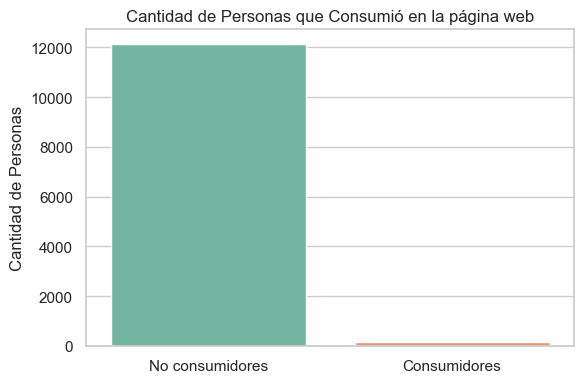

In [41]:
plt.figure(figsize=(6, 4))
sns.set(style="whitegrid")
sns.countplot(x=df_traffic_final['transactionRevenue'].apply(lambda x: 'Consumidores' if x != 0 else 'No consumidores'), palette="Set2")
plt.title('Cantidad de Personas que Consumió en la página web')
plt.xlabel('')
plt.ylabel('Cantidad de Personas')
plt.tight_layout()
plt.show()

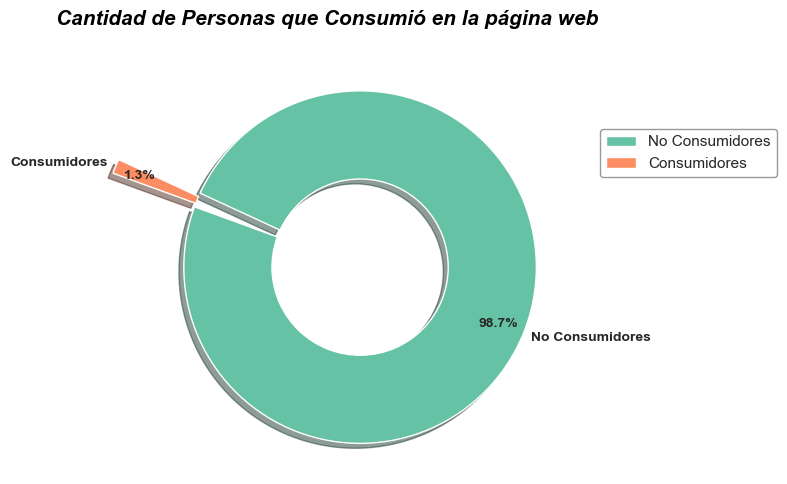

In [42]:
## Gráfico de Pie
valores = df_traffic_final['transactionRevenue'].apply(lambda x: 'Consumidores' if x != 0 else 'No consumidores').value_counts()
etiqueta = ['No Consumidores','Consumidores']
explode = (0.2, 0.3)
# data = [150, 80]
# colors = plt.cm.Blues(data)
# colors2 = plt.cm.viridis(data)
#plt.cm.Set2.colors

plt.figure(figsize=(8,5))
plt.pie(valores,labels=etiqueta, explode=explode,autopct='%1.1f%%', textprops={'fontsize': 10,'weight': 'bold'}, pctdistance=0.85, 
        startangle=160, wedgeprops=dict(width=0.5, edgecolor='w'), labeldistance=1.05, colors=plt.cm.Set2.colors, shadow=True)
    
plt.title('Cantidad de Personas que Consumió en la página web', fontdict={'fontsize': 15, 'fontweight': 'bold', 'color': 'Black',
    'family': 'sans-serif',
    'style': 'italic'})
plt.legend(etiqueta, bbox_to_anchor=((1.1,0.8)), frameon=True, edgecolor='gray')
plt.tight_layout()
plt.show()

* Observamos que la cantidad de personas que consumieron al visitar la página web es mínima comparado con las personas que no consumieron nada.
* Esto nos indica que nuestra data está muy desbalanceada.

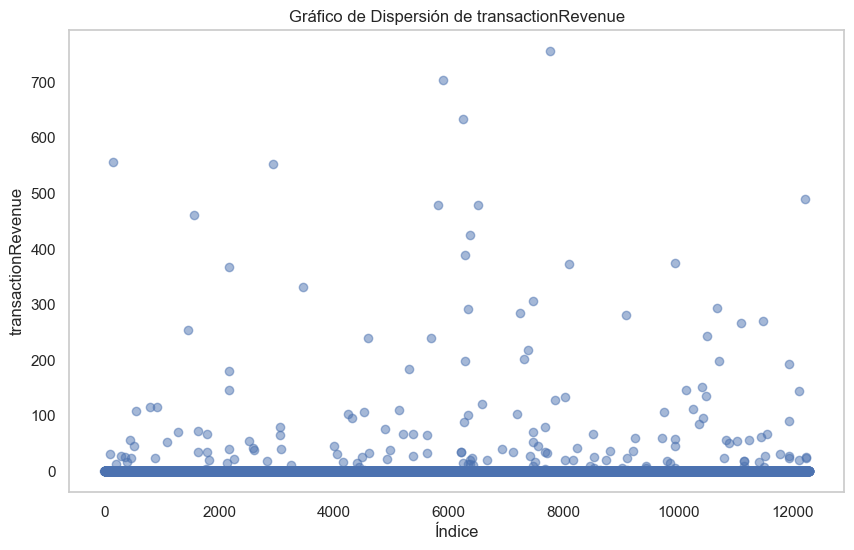

In [43]:
# Grafico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(range(len(df_traffic_final['transactionRevenue'])), df_traffic_final['transactionRevenue'], alpha=0.5)
plt.title('Gráfico de Dispersión de transactionRevenue')
plt.xlabel('Índice')
plt.ylabel('transactionRevenue')
plt.grid(False)
plt.show()

* En la gráfica de dispersión, notamos que casi todos nuestros datos de esta variable se sitúan en el valor cero. 
* Esto nos indica que la mayor cantidad de personas que visitan la página web no concretan la compra.
* Las personas que realizan un gasto elevado, es mínimo.

**FEATURE ENGINEERING**

In [44]:
## Visualizamos el dataframe
df_traffic_final.head()

,channelGrouping,date,visitNumber,visitStartTime,deviceCategory,isMobile,city,metro,hits,pageviews,bounces,newVisits,transactionRevenue,campaign,source,medium,isTrueDirect
0,Organic Search,2016-09-02,1,2016-09-02 08:23:27,desktop,False,Singapore,(not set),1,1,1,1,0.0,(not set),google,organic,False
1,Organic Search,2016-09-02,1,2016-09-02 17:05:28,desktop,False,not available in demo dataset,not available in demo dataset,1,1,1,1,0.0,(not set),google,organic,False
2,Affiliates,2016-09-02,1,2016-09-02 22:53:22,desktop,False,Buenos Aires,(not set),1,1,1,1,0.0,Data Share Promo,Partners,affiliate,False
3,Organic Search,2016-09-02,2,2016-09-03 05:14:09,mobile,True,not available in demo dataset,not available in demo dataset,1,1,1,0,0.0,(not set),google,organic,True
4,Organic Search,2016-09-02,1,2016-09-02 15:21:11,mobile,True,not available in demo dataset,not available in demo dataset,5,4,0,1,0.0,(not set),google,organic,False


In [45]:
## Creamos nuevas variables de tiempo a partir de la variable 'date'
df_traffic_final['year'] = df_traffic_final.date.dt.year
df_traffic_final['month'] = df_traffic_final.date.dt.month
df_traffic_final['day'] = df_traffic_final.date.dt.day
df_traffic_final['quartermonth'] = df_traffic_final.date.dt.quarter
df_traffic_final['weekday'] = df_traffic_final.date.dt.day_name()
df_traffic_final.head()

,channelGrouping,date,visitNumber,visitStartTime,deviceCategory,isMobile,city,metro,hits,pageviews,bounces,newVisits,transactionRevenue,campaign,source,medium,isTrueDirect,year,month,day,quartermonth,weekday
0,Organic Search,2016-09-02,1,2016-09-02 08:23:27,desktop,False,Singapore,(not set),1,1,1,1,0.0,(not set),google,organic,False,2016,9,2,3,Friday
1,Organic Search,2016-09-02,1,2016-09-02 17:05:28,desktop,False,not available in demo dataset,not available in demo dataset,1,1,1,1,0.0,(not set),google,organic,False,2016,9,2,3,Friday
2,Affiliates,2016-09-02,1,2016-09-02 22:53:22,desktop,False,Buenos Aires,(not set),1,1,1,1,0.0,Data Share Promo,Partners,affiliate,False,2016,9,2,3,Friday
3,Organic Search,2016-09-02,2,2016-09-03 05:14:09,mobile,True,not available in demo dataset,not available in demo dataset,1,1,1,0,0.0,(not set),google,organic,True,2016,9,2,3,Friday
4,Organic Search,2016-09-02,1,2016-09-02 15:21:11,mobile,True,not available in demo dataset,not available in demo dataset,5,4,0,1,0.0,(not set),google,organic,False,2016,9,2,3,Friday


In [46]:
## Categorizamos nuestra variable 'visitStartTime' para los diferentes rangos de horario
df_traffic_final['visitStartTime'] = pd.to_datetime(df_traffic_final['visitStartTime'])
df_traffic_final['time_range'] = pd.cut(df_traffic_final.visitStartTime.dt.hour, bins=[0, 6, 12, 18, 24], 
                                  labels=['madrugada', 'mañana', 'tarde', 'noche'], ordered=False).astype('object')
df_traffic_final.head()

,channelGrouping,date,visitNumber,visitStartTime,deviceCategory,isMobile,city,metro,hits,pageviews,bounces,newVisits,transactionRevenue,campaign,source,medium,isTrueDirect,year,month,day,quartermonth,weekday,time_range
0,Organic Search,2016-09-02,1,2016-09-02 08:23:27,desktop,False,Singapore,(not set),1,1,1,1,0.0,(not set),google,organic,False,2016,9,2,3,Friday,mañana
1,Organic Search,2016-09-02,1,2016-09-02 17:05:28,desktop,False,not available in demo dataset,not available in demo dataset,1,1,1,1,0.0,(not set),google,organic,False,2016,9,2,3,Friday,tarde
2,Affiliates,2016-09-02,1,2016-09-02 22:53:22,desktop,False,Buenos Aires,(not set),1,1,1,1,0.0,Data Share Promo,Partners,affiliate,False,2016,9,2,3,Friday,noche
3,Organic Search,2016-09-02,2,2016-09-03 05:14:09,mobile,True,not available in demo dataset,not available in demo dataset,1,1,1,0,0.0,(not set),google,organic,True,2016,9,2,3,Friday,madrugada
4,Organic Search,2016-09-02,1,2016-09-02 15:21:11,mobile,True,not available in demo dataset,not available in demo dataset,5,4,0,1,0.0,(not set),google,organic,False,2016,9,2,3,Friday,tarde


In [47]:
## Eliminamos las columnas originales que nos sirvieron para crear las demás variables
df_traffic_final = df_traffic_final.drop(columns=['date','visitStartTime'])
df_traffic_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12283 entries, 0 to 12282
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   channelGrouping     12283 non-null  object 
 1   visitNumber         12283 non-null  int64  
 2   deviceCategory      12283 non-null  object 
 3   isMobile            12283 non-null  bool   
 4   city                12283 non-null  object 
 5   metro               12283 non-null  object 
 6   hits                12283 non-null  int64  
 7   pageviews           12283 non-null  int64  
 8   bounces             12283 non-null  int64  
 9   newVisits           12283 non-null  int64  
 10  transactionRevenue  12283 non-null  float64
 11  campaign            12283 non-null  object 
 12  source              12283 non-null  object 
 13  medium              12283 non-null  object 
 14  isTrueDirect        12283 non-null  bool   
 15  year                12283 non-null  int64  
 16  mont

### 3.1.2 ANÁLISIS UNIVARIADO:  VARIABLES NUMÉRICAS

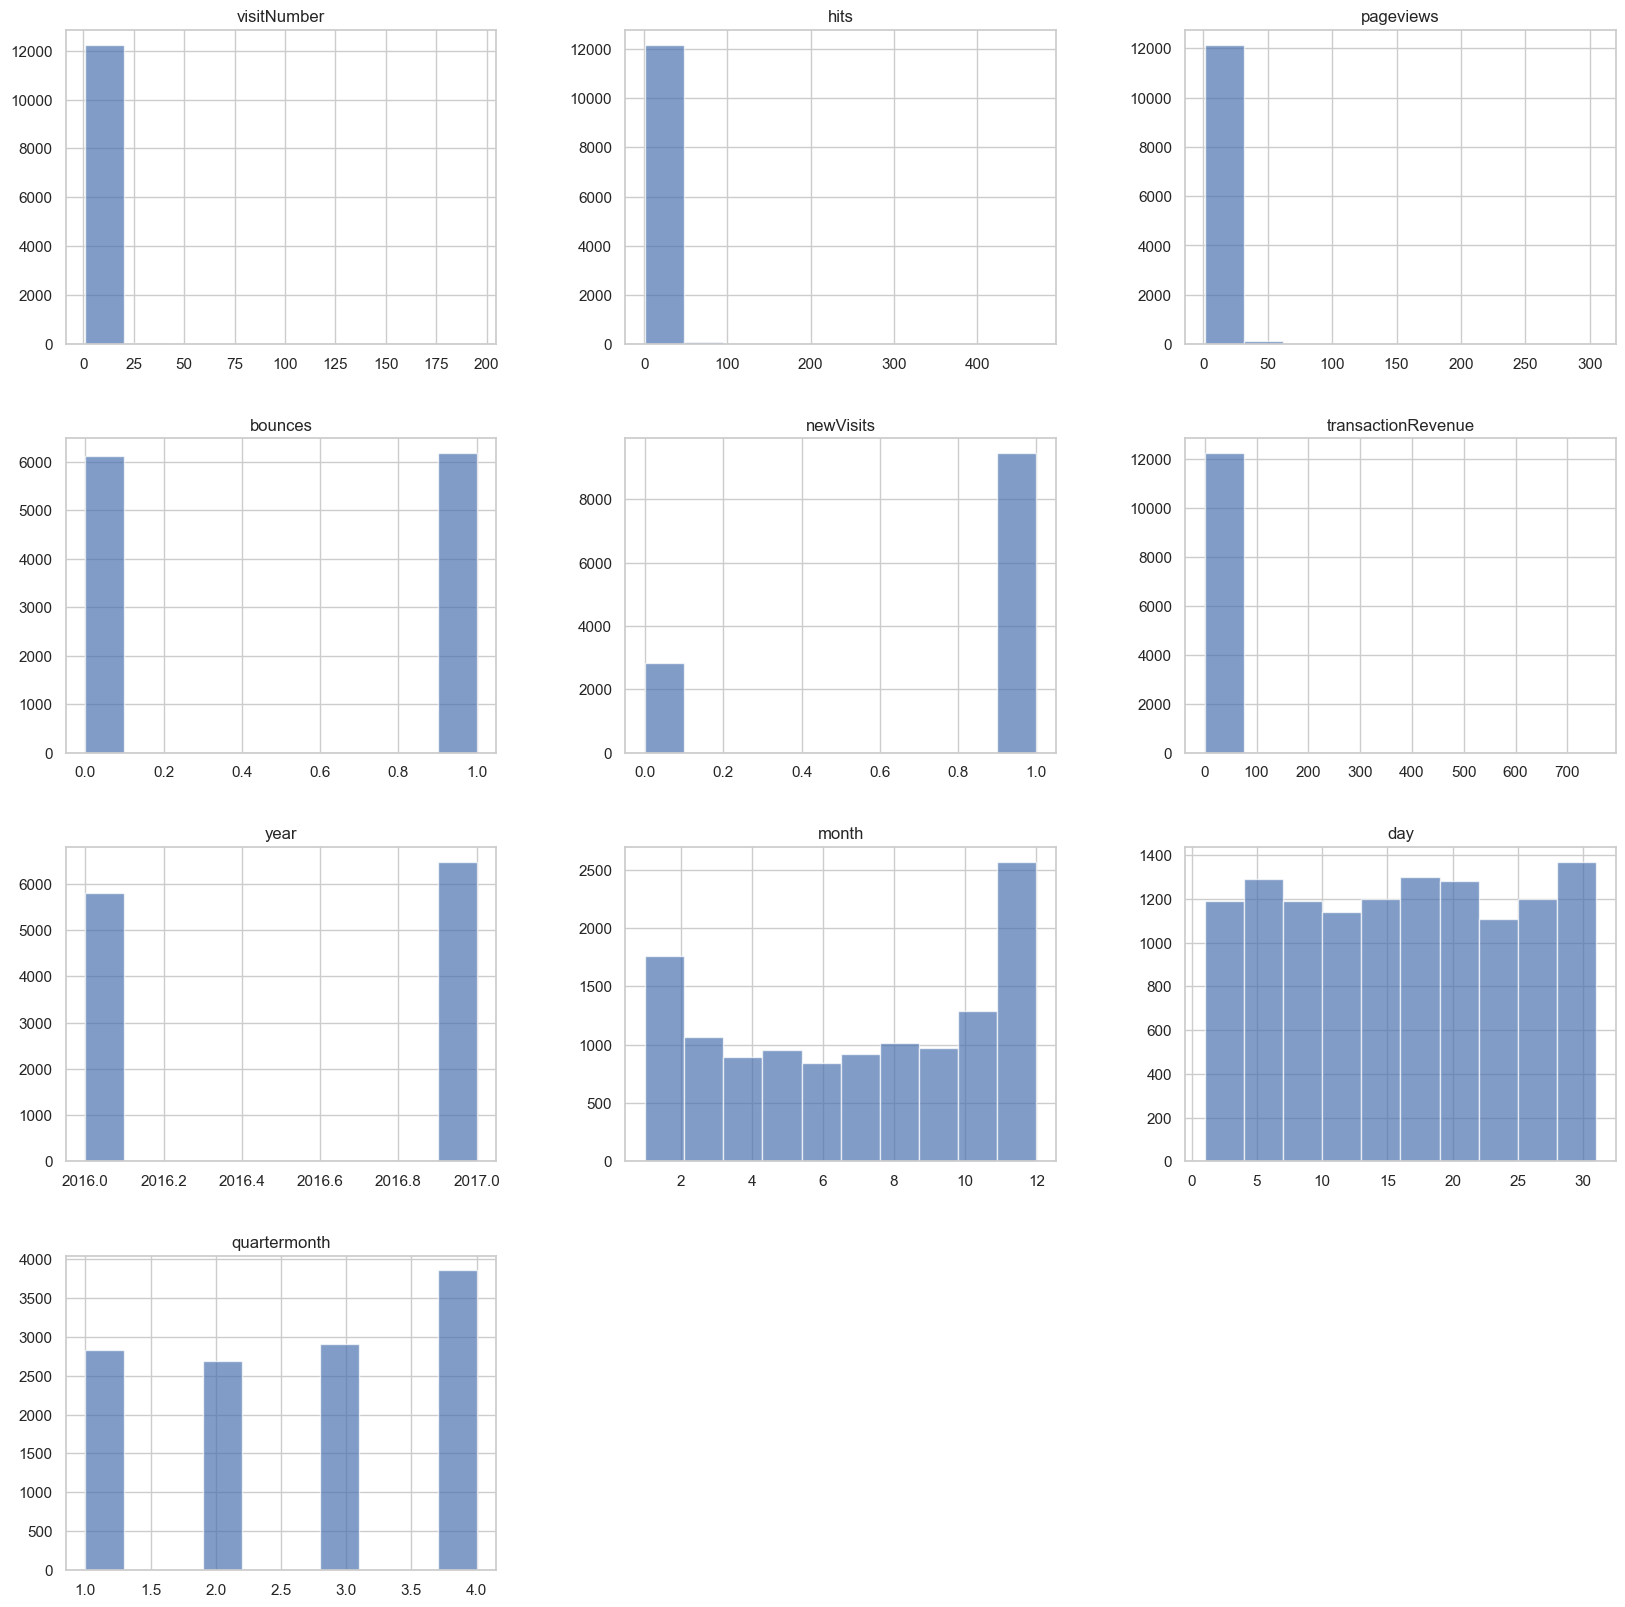

In [48]:
# Dibujamos gráfica de frecuencia de todos los atributos
plt.rcParams['figure.figsize'] = [20,20];
sns.set(style="whitegrid")
df_traffic_final.hist(alpha=0.7)
plt.show()

### 3.1.3 ANÁLISIS UNIVARIADO:  VARIABLES CATEGÓRICAS

* En esta parte para poder graficar de mejor manera, hemos decidido separar nuestras variables cualitativas en dos grupos, los que tienen varias subcategorías y las que tienen menos.
* Se separaron en variables con alto conteo y con bajo conteo.

In [49]:
## Las variables cualitativas de nuestro dataframe
variables_cualitativas = df_traffic_final.drop(columns=df_traffic_final.describe().columns).columns
variables_cualitativas

Index(['channelGrouping', 'deviceCategory', 'isMobile', 'city', 'metro',
       'campaign', 'source', 'medium', 'isTrueDirect', 'weekday',
       'time_range'],
      dtype='object')

In [50]:
## Separamos nuestras variables cualitativas que tienen muchas subcategorias y con nombres muy largos
variables_cualitativas_alto_conteo = ['city','metro','campaign','source']

In [51]:
## Se filtra las varibles con poco conteo de subcategorias
variables_cualitativas_filtradas = [variable for variable in variables_cualitativas if variable not in variables_cualitativas_alto_conteo]
variables_cualitativas_filtradas

['channelGrouping',
 'deviceCategory',
 'isMobile',
 'medium',
 'isTrueDirect',
 'weekday',
 'time_range']

**GRAFICANDO VARIABLES CUALITATIVAS CON POCAS SUBCATEGORIAS**

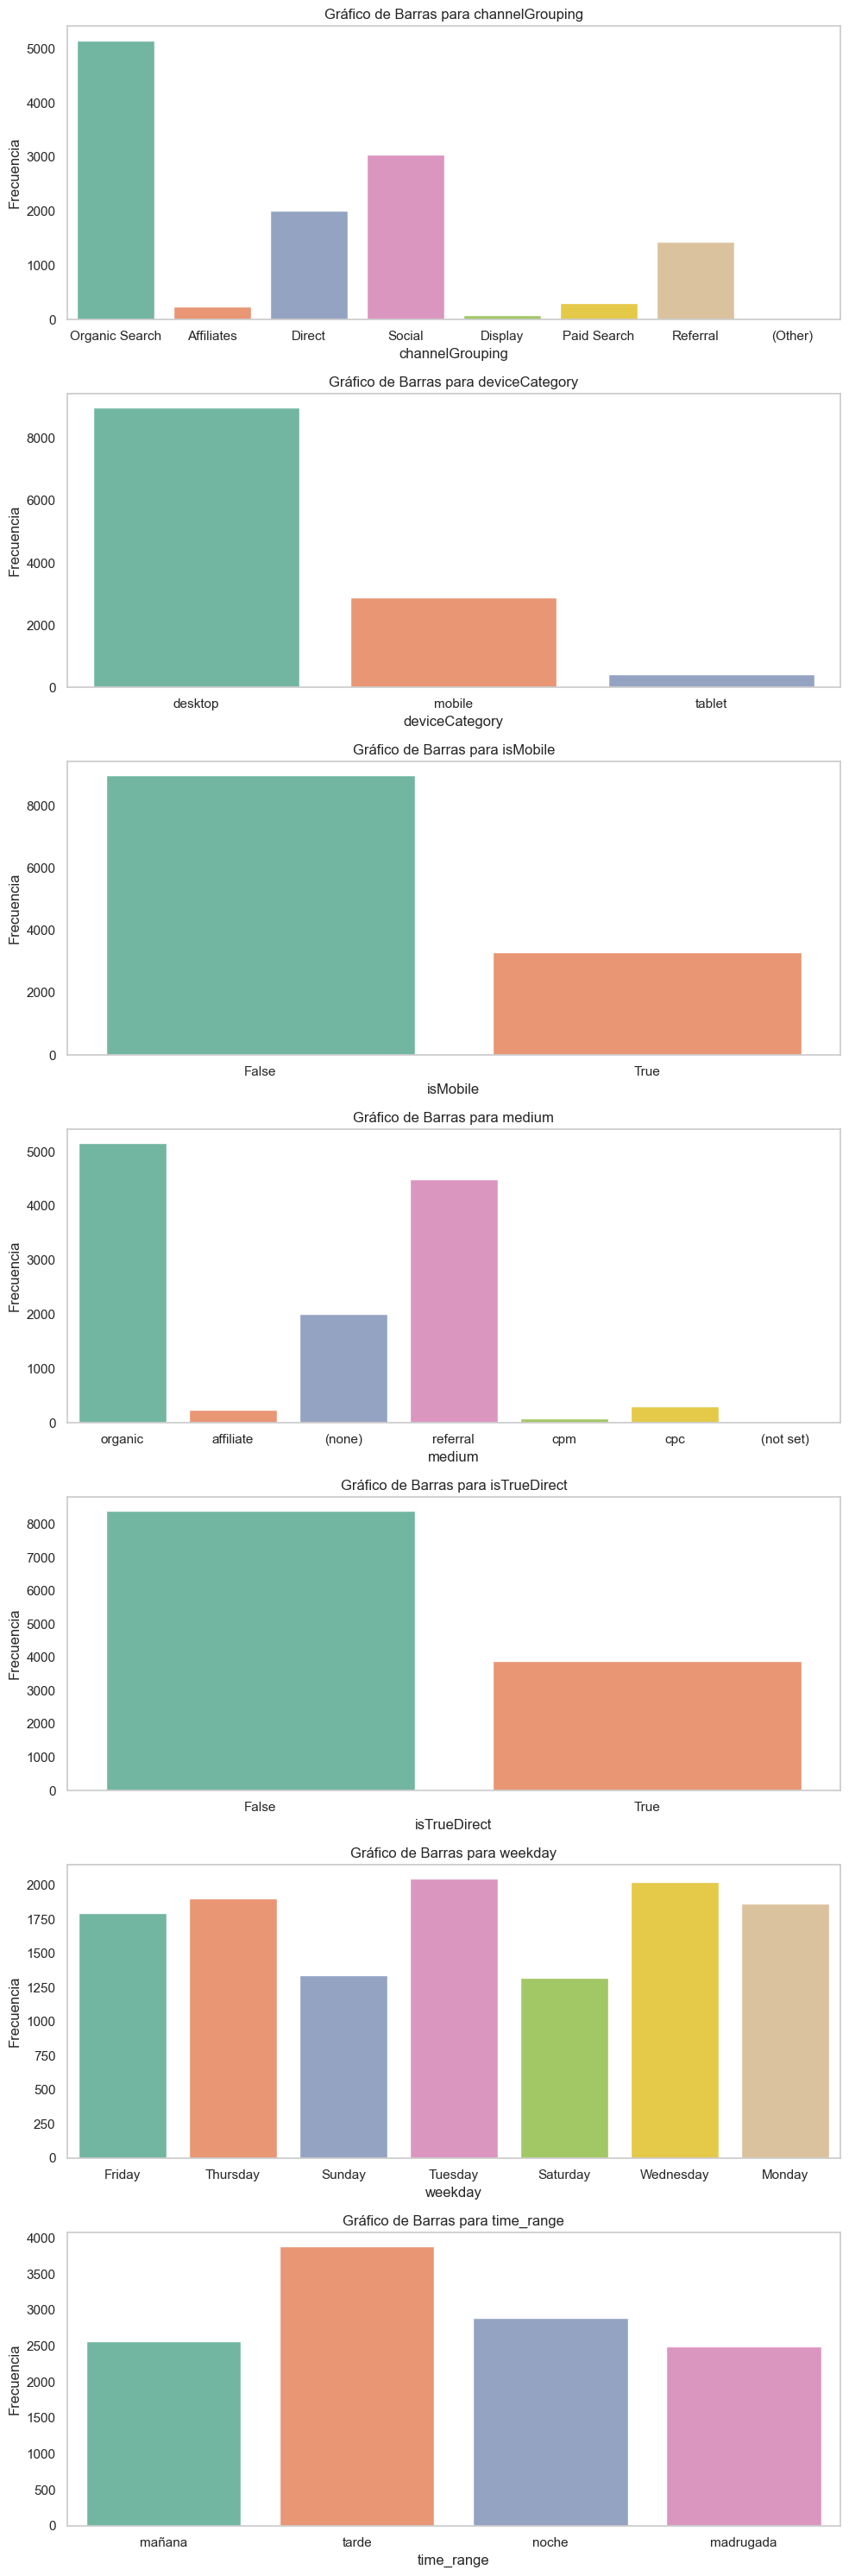

In [52]:
fig, axs = plt.subplots(nrows=len(variables_cualitativas_filtradas), figsize=(10, 30))

# Iteramos sobre cada variable cualitativa y creamos un gráfico de barras para cada una
for i, variable in enumerate(variables_cualitativas_filtradas):
    sns.countplot(data=df_traffic_final, x=variable, ax=axs[i], palette="Set2")
    axs[i].set_title(f'Gráfico de Barras para {variable}')
    axs[i].set_ylabel('Frecuencia')
    axs[i].grid(False)

plt.tight_layout()
plt.show()

**GRAFICANDO VARIABLES CUALITATIVAS CON MUCHAS SUBCATEGORIAS**

In [53]:
## Observamos cuales son estas variables
df_traffic_final[variables_cualitativas_alto_conteo]

,city,metro,campaign,source
0,Singapore,(not set),(not set),google
1,not available in demo dataset,not available in demo dataset,(not set),google
2,Buenos Aires,(not set),Data Share Promo,Partners
3,not available in demo dataset,not available in demo dataset,(not set),google
4,not available in demo dataset,not available in demo dataset,(not set),google
...,...,...,...,...
12278,not available in demo dataset,not available in demo dataset,(not set),youtube.com
12279,not available in demo dataset,not available in demo dataset,(not set),youtube.com
12280,not available in demo dataset,not available in demo dataset,(not set),youtube.com
12281,not available in demo dataset,not available in demo dataset,(not set),youtube.com


* Deseamos graficar estos datos, pero al tener demasiadas subcategorias y además nombres muy largos, decidimos convertir algunos nombres para que se pueda visualizar de mejor manera las gráficas.

In [54]:
## Reemplazando algunos nombres para poder obtener mejores gráficas
df_traffic_final.replace('not available in demo dataset', 'not available', inplace=True)
df_traffic_final.replace('Retail (DO NOT EDIT owners nophakun and tianyu)', 'Retail', inplace=True)
df_traffic_final.replace('San Francisco-Oakland-San Jose CA', 'San Francisco', inplace=True)
df_traffic_final.replace('AW - Dynamic Search Ads Whole Site', 'AW - Dynamic Search', inplace=True)

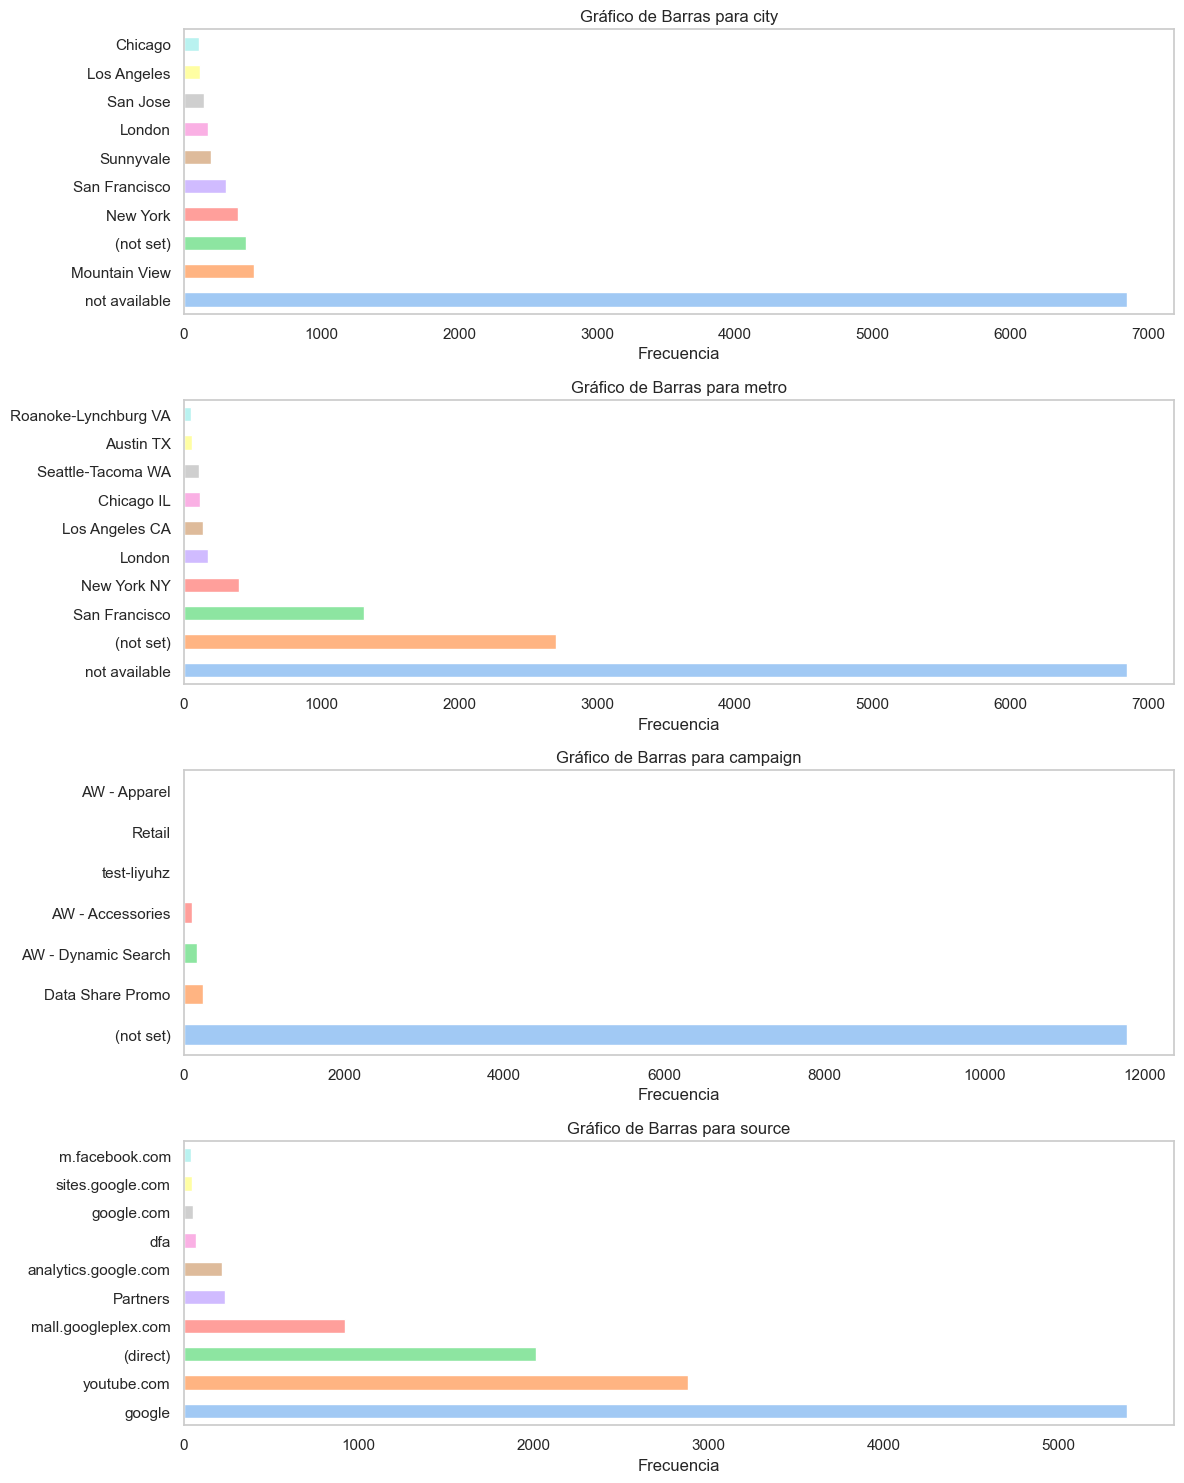

In [55]:
fig, axs = plt.subplots(nrows=df_traffic_final[['city','metro','campaign','source']].shape[1], figsize=(12, 15))

# Iteramos sobre cada variable cualitativa y creamos un gráfico de barras horizontal para cada una
for i, variable in enumerate(list(df_traffic_final[['city','metro','campaign','source']].columns)):
    # Calculamos el recuento de cada valor único en la columna y seleccionamos el Top10
    top_10_categorias = df_traffic_final[variable].value_counts().head(10)
    
    # Creamos el gráfico de barras
    top_10_categorias.plot(kind='barh', color=sns.color_palette("pastel"), ax=axs[i])
    
    axs[i].set_title(f'Gráfico de Barras para {variable}')
    axs[i].set_xlabel('Frecuencia')
    axs[i].grid(False)

plt.tight_layout()
plt.show()

### 3.2 ANÁLISIS BIVARIADO 

* En este punto, observamos que poseemos muchas variables categóricas, es así que decidimos realizar una codificación para las variables categóricas, con la finalidad de poder conseguir valores numéricos que se puedan incorporar en nuestros análisis.

In [56]:
## Codificando nuestras variables cualitativas
from sklearn.preprocessing import LabelEncoder
for columna in variables_cualitativas:
    lbl = LabelEncoder()
    strings = list(df_traffic_final[columna].values.astype('str'))
    lbl.fit(strings)
    df_traffic_final[columna] = lbl.transform(strings)

In [57]:
## Validamos que se hayan codificado todas las variables cualitativas
df_traffic_final

,channelGrouping,visitNumber,deviceCategory,isMobile,city,metro,hits,pageviews,bounces,newVisits,transactionRevenue,campaign,source,medium,isTrueDirect,year,month,day,quartermonth,weekday,time_range
0,4,1,0,0,250,0,1,1,1,1,0.0,0,23,5,0,2016,9,2,3,0,1
1,4,1,0,0,295,52,1,1,1,1,0.0,0,23,5,0,2016,9,2,3,0,4
2,1,1,0,0,43,0,1,1,1,1,0.0,4,3,2,0,2016,9,2,3,0,3
3,4,2,1,1,295,52,1,1,1,0,0.0,0,23,5,1,2016,9,2,3,0,0
4,4,1,1,1,295,52,5,4,0,1,0.0,0,23,5,0,2016,9,2,3,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12278,7,1,0,0,295,52,1,1,1,1,0.0,0,75,6,0,2017,1,4,1,6,4
12279,7,1,1,1,295,52,1,1,1,1,0.0,0,75,6,0,2017,1,4,1,6,0
12280,7,1,0,0,295,52,1,1,1,1,0.0,0,75,6,0,2017,1,4,1,6,0
12281,7,2,1,1,295,52,2,2,0,0,0.0,0,75,6,1,2017,1,4,1,6,1


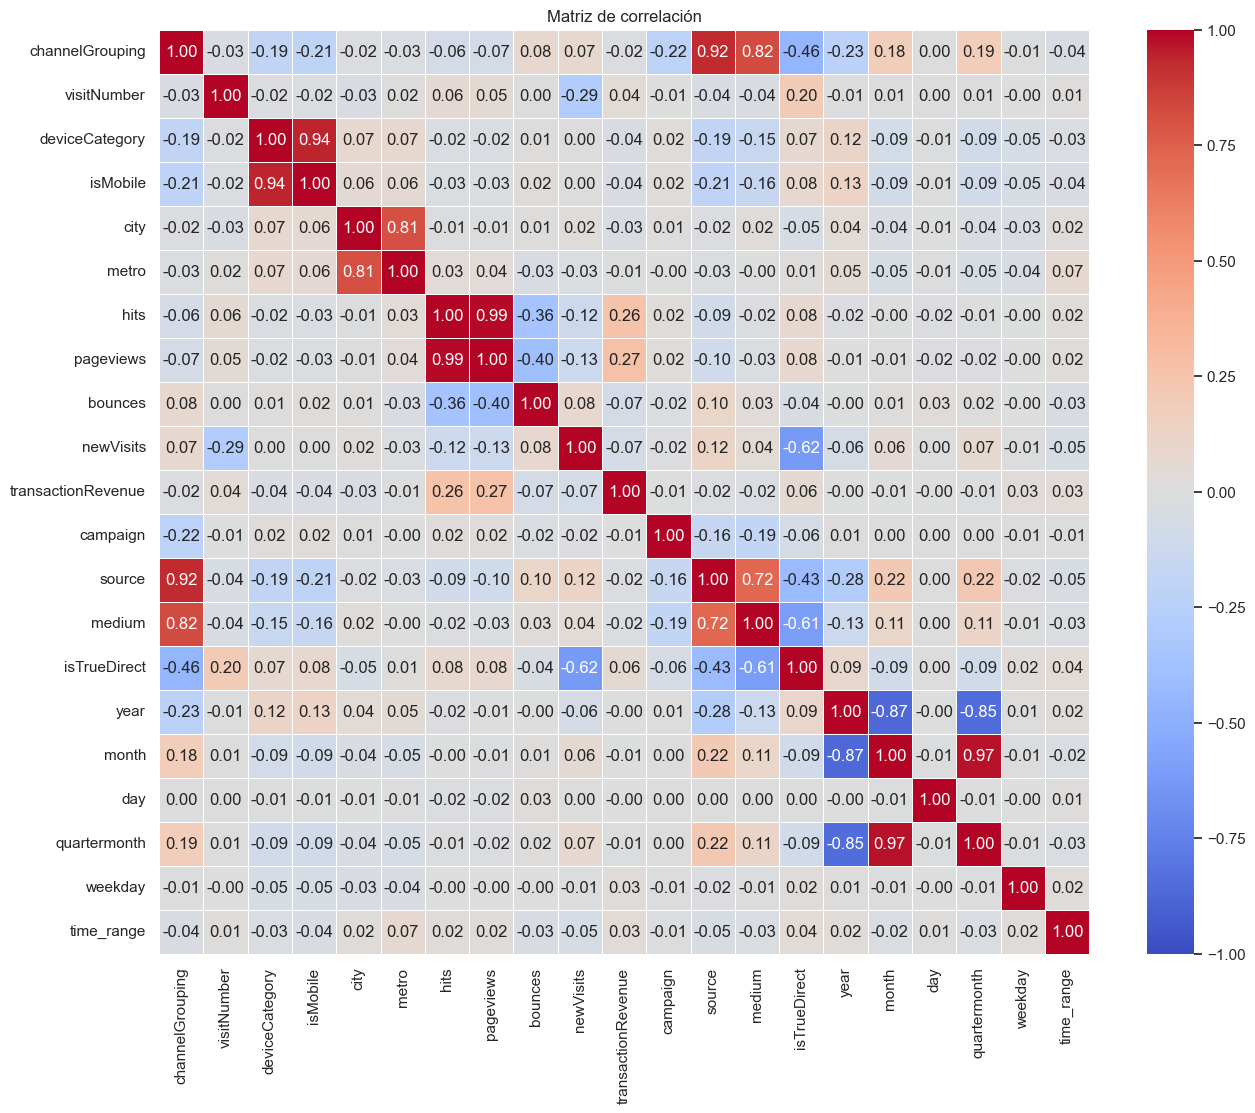

In [58]:
## Realizando un Hetamap para observar la correlación entre variables
plt.figure(figsize=(15, 12))
sns.heatmap(df_traffic_final.corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de correlación')
plt.show()

* Notamos que la variable **year**, no tiene nada de correlación con la variable objetivo, al analizar en el gráfico de frecuencias, vemos que existe casi la misma cantidad para el año 2016 o 2017, con lo cual esto no nos estaría aportando mucho valor al momento de querer segmentar. Asimismo, esta variable tiene correlación muy alta con otras variables de tiempo. Decidimos eliminar esta variable ya que poseemos otras variables de tiempo.
* La variable **day**, al igual que la variable 'year', al ver su gráfica de frecuencia notamos que todos los dias tienen la misma frecuencia, lo cual no nos ayudaría a discriminar en nuestro modelo. Además notamos que no tiene nada de correlación con la variable objetivo. Decidimos eliminar esta variable.
* Las variables **month** y **quartermonth**, tampoco tienen correlación con la variable objetivo, notamos que tienen la misma tendencia, se correlacionan mucho entre ellas. En la gráfica de frecuencia, notamos esta correlación de la misma manera. Consideramos que descartaremos **quartermonth**, ya que para nosotros segmentar por **month**, es más importante en nuestro posterior análisis consiguiendo los mismos resultados de segmentación.
* Las variables **hits** y **pageviews**, son las que tienen mas correlación con la variable objetivo, aunque no es muy alta. Sin embargo, estas dos variables y **bounces** se relacionan mucho entre ellas. Si bien es cierto podriamos descartarlas, pero notamos que estos datos pueden ser relevantes para nuestro modelo, mantendremos estas variables.
* Observamos que las variables **chanelGrouping**, **source**, **medium** y **isTrueDirect**, tienen alta correlación entre ellas, esto podría generarnos multicolinealidad que podría perjudicarnos en nuestro modelo. Sin embargo, al analizar estas variables con sus frecuencias y significados, notamos que pueden ser de relevancia para el modelo, decidimos mantener estas variables por el momento.
* Las variables **isMobile** y **deviceCategory**, tienen cierta correlación entre las variables. También notamos que no tienen mucha correlación con la variable objetivo y además los dos representan algo parecido. Debido a esto y después de analizar, decidimos prescindir de **isMobile**, consideramos que la otra variable nos aportará lo que necesitamos al modelo.
* Las variables **newVisits** y **visitNumber**, notamos que tienen cierta correlación entre ellas, pero con la variable objetivo casi nada de correlación. En este punto notamos que nos representan algo parecido, pero también consideramos que nos aportan valor para nuestro objetivo. Es asi que dedidimos mantener estas variables.
* Las variables **city** y **metro**, tienen una muy alta correlación entre ellas, notamos que son algo parecidas. No tienen casi nada de correlación con la variable objetivo. En este punto, por el momento decidimos prescindir de la variable **metro** ya que observamos en las gráficas de frecuencias que tenemos más datos variados para **city**, lo cual puede ser beneficioso para nuestra segmentación en el modelo.
* Las demás variables, consideramos que deben continuar.

In [59]:
## Variables que decidimos eliminar después de nuestro análisis
variables_prescindir = ['metro','year','day','quartermonth','isMobile']

In [60]:
## Eliminamos las varaibles en nuestro dataframe
df_traffic_new = df_traffic_final.copy()
df_traffic_new = df_traffic_new.drop(columns=variables_prescindir)
df_traffic_new

,channelGrouping,visitNumber,deviceCategory,city,hits,pageviews,bounces,newVisits,transactionRevenue,campaign,source,medium,isTrueDirect,month,weekday,time_range
0,4,1,0,250,1,1,1,1,0.0,0,23,5,0,9,0,1
1,4,1,0,295,1,1,1,1,0.0,0,23,5,0,9,0,4
2,1,1,0,43,1,1,1,1,0.0,4,3,2,0,9,0,3
3,4,2,1,295,1,1,1,0,0.0,0,23,5,1,9,0,0
4,4,1,1,295,5,4,0,1,0.0,0,23,5,0,9,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12278,7,1,0,295,1,1,1,1,0.0,0,75,6,0,1,6,4
12279,7,1,1,295,1,1,1,1,0.0,0,75,6,0,1,6,0
12280,7,1,0,295,1,1,1,1,0.0,0,75,6,0,1,6,0
12281,7,2,1,295,2,2,0,0,0.0,0,75,6,1,1,6,1


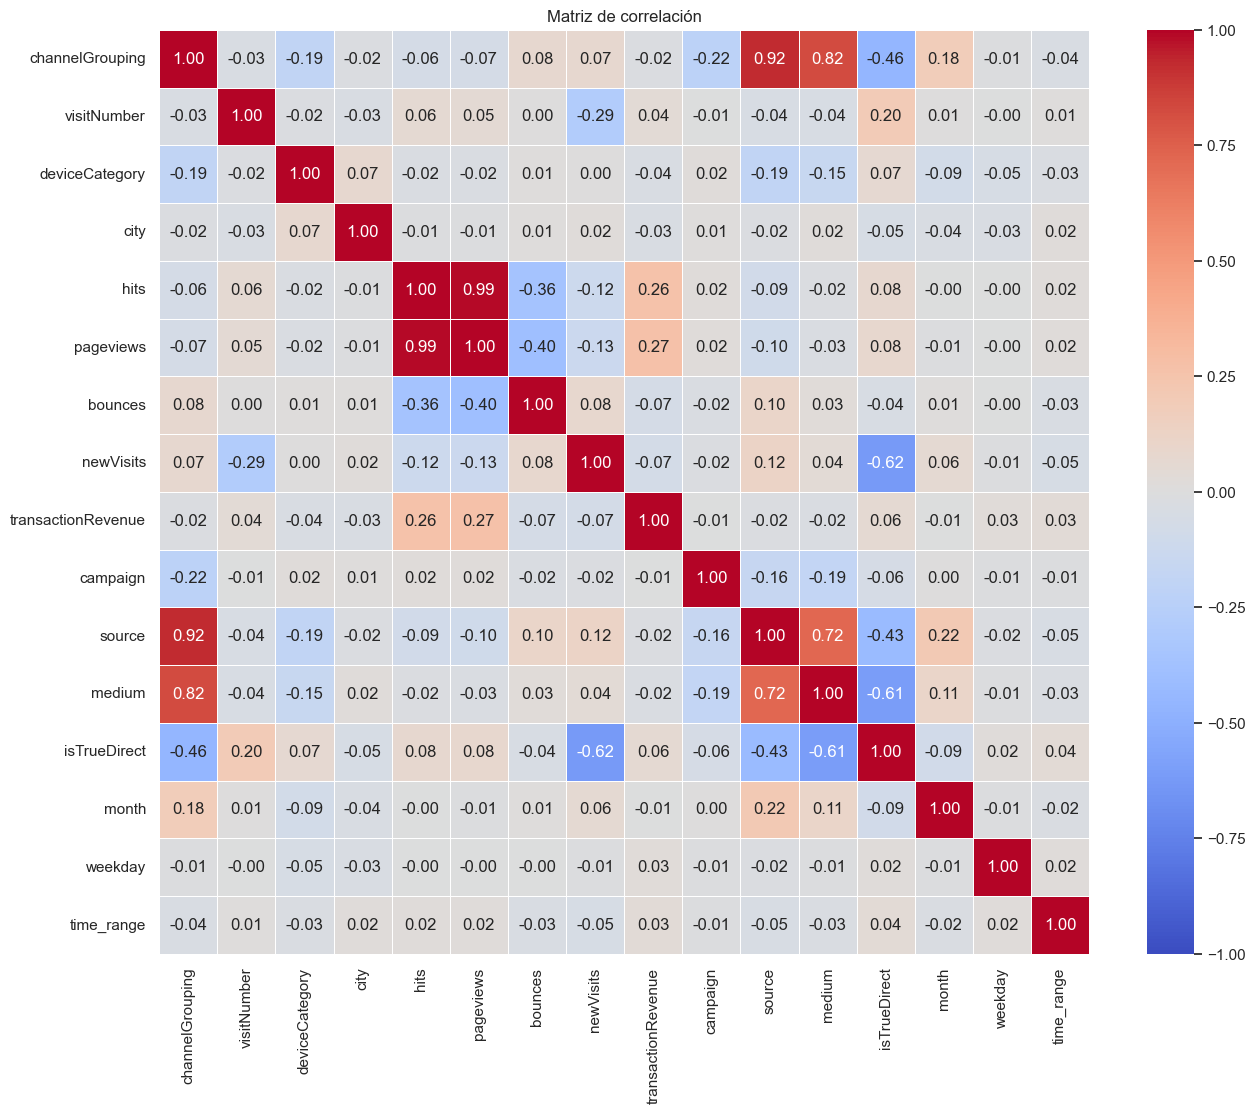

In [61]:
## Realizando un Hetamap para observar la correlación entre variables
plt.figure(figsize=(15, 12))
sns.heatmap(df_traffic_new.corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de correlación')
plt.show()

* Consideramos que ha mejorado un poco nuestras correlaciones.
* Las variables que se siguen correlacionando, decidimos mantenerlas, ya que para nosotros son importantes para el análisis.

In [62]:
df_traffic_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12283 entries, 0 to 12282
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   channelGrouping     12283 non-null  int32  
 1   visitNumber         12283 non-null  int64  
 2   deviceCategory      12283 non-null  int32  
 3   city                12283 non-null  int32  
 4   hits                12283 non-null  int64  
 5   pageviews           12283 non-null  int64  
 6   bounces             12283 non-null  int64  
 7   newVisits           12283 non-null  int64  
 8   transactionRevenue  12283 non-null  float64
 9   campaign            12283 non-null  int32  
 10  source              12283 non-null  int32  
 11  medium              12283 non-null  int32  
 12  isTrueDirect        12283 non-null  int32  
 13  month               12283 non-null  int64  
 14  weekday             12283 non-null  int32  
 15  time_range          12283 non-null  int32  
dtypes: f

## 4. CONSTRUCCIÓN DE MODELOS 

### 4.1 CREANDO UN MODELO DE CLASIFICACIÓN

* Generamos este modelo de clasifiación inicial, a fin de poder generar una nueva variable que nos ayude a segmentar nuestros valores y asi poder incorporarlo a nuestros modelos de regresión.

In [63]:
## Realizamos un modelo de clasificación con la finalidad de tener una variable más para nuestro modelo de regresión
x = df_traffic_new.drop(columns='transactionRevenue')
y = df_traffic_new['transactionRevenue'].apply(lambda x: 0 if x==0 else 1)

In [64]:
## Estandarizamos nuestros datos
scaled = StandardScaler()
x_scaled = scaled.fit_transform(x)

In [65]:
## Separamos la data en entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size = 0.20, random_state=42)

In [66]:
## Entrenando el modelo con los datos de entrenamiento
model_classif = RandomForestClassifier(n_estimators=100, random_state=42)
model_classification = model_classif.fit(x_train,y_train)

In [67]:
## Verificando la precisión del modelo
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, model_classification.predict(x_test))
print("Accuracy:", accuracy)

Accuracy: 0.986975986975987


### 4.2 CREADO LOS MODELOS DE REGRESIÓN 

In [69]:
## Entrenando nuestros datos previo a incorporarlo a los modelos de regresión
x = df_traffic_new.drop(columns='transactionRevenue')
y = df_traffic_new['transactionRevenue']

## Estandarizamos nuestros datos
scaled = StandardScaler()
x_scaled_before = scaled.fit_transform(x)

x['classification'] = model_classification.predict(x_scaled_before)

## Estandarizamos nuevamente nuestros datos
scaled = StandardScaler()
x_scaled_after = scaled.fit_transform(x)

## Separamos la data en entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(x_scaled_after, y, test_size = 0.30, random_state=42)

### 4.2.1 MODELO LGB 

In [70]:
# Definiendo Hiperparámetros para el modelo
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 50,
    'learning_rate': 0.01,
    'bagging_fraction': 0.75,
    'feature_fraction': 0.80,
    'bagging_frequency': 5,
    'force_row_wise': True,
    'verbose': -1,
    'predict_disable_shape_check': True
}

# Definiendo los conjuntos de datos de entrenamiento y validación
lgb_train = lgb.Dataset(x_train, label=y_train)
lgb_val = lgb.Dataset(x_test, label=y_test)

# Entrenando el modelo
lgb_model = lgb.train(
    params=lgb_params,
    train_set=lgb_train,
    num_boost_round=700,
    valid_sets=(lgb_val)
)

In [71]:
## Realizando las predicciones
lgb_predictions = lgb_model.predict(x_test, num_iteration = lgb_model.best_iteration)
lgb_predictions[lgb_predictions<0] = 0

**R2 - RMSE - MAE**

In [72]:
r2_lgb = r2_score(y_test, lgb_predictions)*100
rmse_lgb = np.sqrt(mean_squared_error(y_test, lgb_predictions))

from sklearn.metrics import mean_absolute_error
mae_lgb = mean_absolute_error(y_test, lgb_predictions) 

lgb_metrics = []
lgb_metrics.extend([r2_lgb, rmse_lgb, mae_lgb])

r2_lgb, rmse_lgb, mae_lgb

(19.967769548535475, 17.479616211024364, 1.5948308549637025)

**VISUALIZACIÓN DE RESIDUOS**

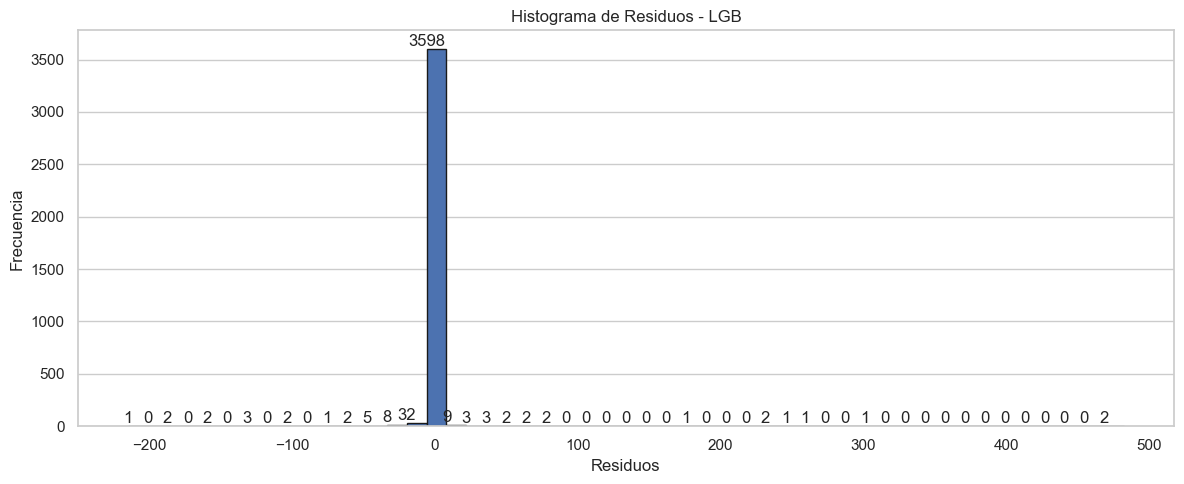

In [73]:
# Visualización de residuos
lgb_residuals = y_test - lgb_predictions

plt.figure(figsize=(12, 5))

# Graficar el histograma de los residuos
hist, bins, _ = plt.hist(lgb_residuals, bins=50, edgecolor='k')

plt.title('Histograma de Residuos - LGB')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
# plt.xlim(-120, 120)
# plt.ylim(0, 50)

# Colocar las frecuencias en la gráfica
for i in range(len(hist)):
    plt.text(bins[i], hist[i], str(int(hist[i])), ha='center', va='bottom')
    
# Ajustar la ubicación de los ticks del eje x
# plt.xticks(np.arange(-120, 121, 20))
plt.grid(axis='x')
plt.tight_layout()    
plt.show()

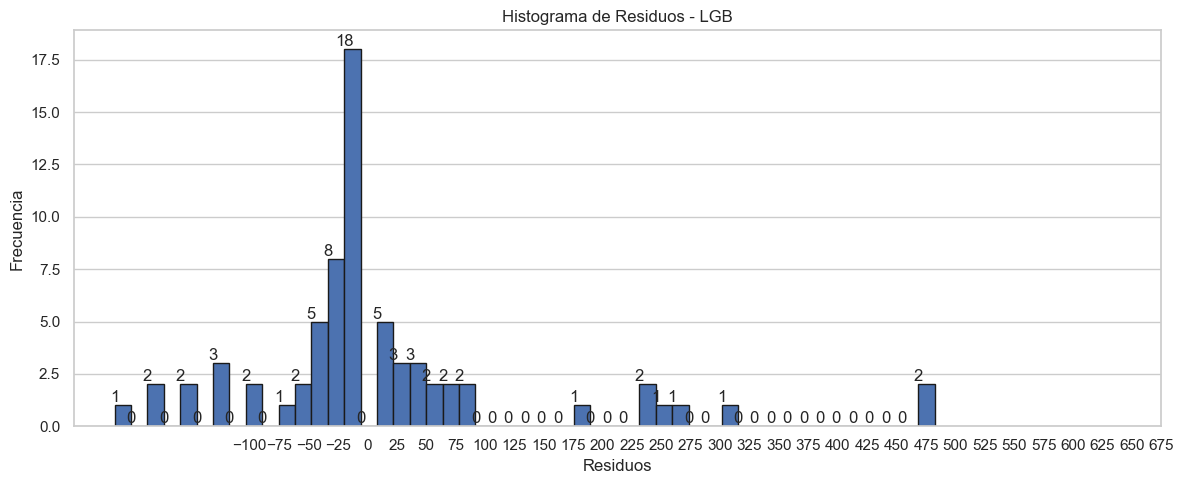

In [74]:
## Verificando nuestros residuos en intervalos menores para ver su distribución
plt.figure(figsize=(12, 5))

lgb_residuals = y_test - lgb_predictions

# Graficar el histograma de los residuos
hist, bins, _ = plt.hist(lgb_residuals[(lgb_residuals != 0) & ((lgb_residuals < -10) | (lgb_residuals > 10))], bins=50, edgecolor='k')

plt.title('Histograma de Residuos - LGB')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
# plt.xlim(-120, 120)
# plt.ylim(0, 50)

# Colocar las frecuencias en la gráfica
for i in range(len(hist)):
    plt.text(bins[i], hist[i], str(int(hist[i])), ha='center', va='bottom')
    
# # Ajustar la ubicación de los ticks del eje x
plt.xticks(np.arange(-100, 700, 25))
plt.grid(axis='x')
plt.tight_layout()    
plt.show()

**PRECISIÓN EN EL MODELO - VALORES DISTINTOS DE CERO**

In [75]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

# Supongamos que 'y_test' son tus valores reales y 'y_pred' son las predicciones de tu modelo

# Binarización de los datos de prueba
y_test_binary = (y_test > 0).astype(int)
y_pred_binary = (lgb_predictions > 0).astype(int)

# Calcular las métricas de clasificación binaria
accuracy = accuracy_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary)
recall = recall_score(y_test_binary, y_pred_binary)
roc_auc = roc_auc_score(y_test_binary, y_pred_binary)

# Imprimir las métricas
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("ROC AUC:", roc_auc)

Accuracy: 0.28331071913161465
Precision: 0.012786761940579166
Recall: 0.68
ROC AUC: 0.4789270976616231


In [76]:
from sklearn.metrics import confusion_matrix

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# Extraer valores de la matriz de confusión
tn, fp, fn, tp = conf_matrix.ravel()

# Calcular métricas adicionales
false_positive_rate = fp / (fp + tn)
false_negative_rate = fn / (fn + tp)

# Imprimir la matriz de confusión y métricas adicionales
print("Matriz de Confusión:")
print(conf_matrix)
print("False Positive Rate:", false_positive_rate)
print("False Negative Rate:", false_negative_rate)

Matriz de Confusión:
[[1010 2625]
 [  16   34]]
False Positive Rate: 0.7221458046767538
False Negative Rate: 0.32


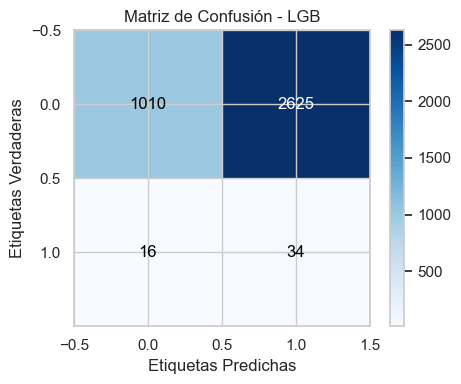

In [77]:
# Configurar la figura
plt.figure(figsize=(5, 4))

# Mostrar la matriz de confusión como una imagen
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)

# Añadir etiquetas de los ejes
plt.title('Matriz de Confusión - LGB')
plt.colorbar()
plt.xlabel('Etiquetas Predichas')
plt.ylabel('Etiquetas Verdaderas')

# Añadir números en las celdas
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")
        
plt.yticks(np.arange(-0.5, 1.5, 0.5))

# Mostrar la gráfica
plt.tight_layout()
plt.show()

### 4.2.2 MODELO XGBOOST 

In [78]:
## Definiendo Hiperparámetros para el modelo
xgb_params = {'objective': 'reg:squarederror',  ##para problemas de regresión
              'eval_metric': 'rmse', ##métrica de evaluación
              'eta': 0.1, ##tasa de aprendizaje
              'ma_depth': 6, ##profundidad máxima del árbol
              'subsample': 0.7, ## proporción de muestras usadas para entrenar cada árbol
              'colsample_bytree': 0.7, ## proporción de características usadas para entrenar cada árbol
              'seed': 42}

# Definiendo los conjuntos de datos de entrenamiento y validación
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label = y_test)
evals = [(dtrain,'train'),(dtest,'test')]

# Entrenando el modelo
xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=1000,
                     evals=evals, early_stopping_rounds=10,
                     verbose_eval=False)

In [79]:
# Convertir los datos de prueba a un objeto DMatrix
dtest = xgb.DMatrix(x_test)

## Realizando las predicciones
xbg_predictions = xgb_model.predict(dtest)
xbg_predictions[xbg_predictions<0] = 0

**R2 - RMSE - MAE**

In [80]:
## Calculando las métricas del modelo
r2_xgb = r2_score(y_test, xbg_predictions)*100
rmse_xgb = np.sqrt(mean_squared_error(y_test, xbg_predictions))

from sklearn.metrics import mean_absolute_error
mae_xgb = mean_absolute_error(y_test, xbg_predictions) 

xgb_metrics = []
xgb_metrics.extend([r2_xgb, rmse_xgb, mae_xgb])

r2_xgb, rmse_xgb, mae_xgb

(19.678409841302035, 17.511186823828705, 1.64060132527272)

**VISUALIZACIÓN DE RESIDUOS**

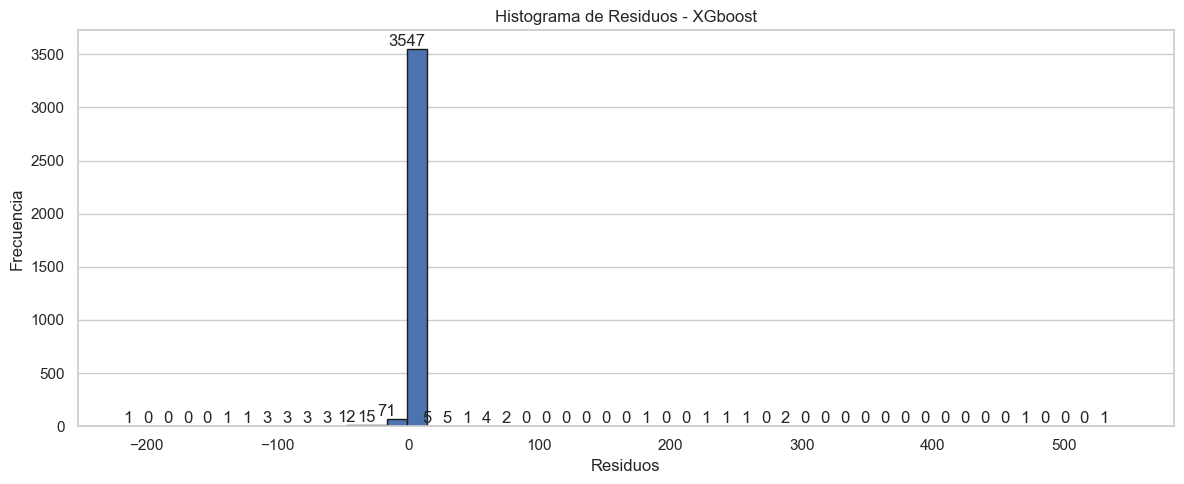

In [81]:
# Visualización de residuos
xbg_residuals = y_test - xbg_predictions

plt.figure(figsize=(12, 5))

# Graficar el histograma de los residuos
hist, bins, _ = plt.hist(xbg_residuals, bins=50, edgecolor='k')

plt.title('Histograma de Residuos - XGboost')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
# plt.xlim(-120, 120)
# plt.ylim(0, 50)

# Colocar las frecuencias en la gráfica
for i in range(len(hist)):
    plt.text(bins[i], hist[i], str(int(hist[i])), ha='center', va='bottom')
    
# Ajustar la ubicación de los ticks del eje x
# plt.xticks(np.arange(-120, 121, 20))
plt.grid(axis='x')
plt.tight_layout()    
plt.show()

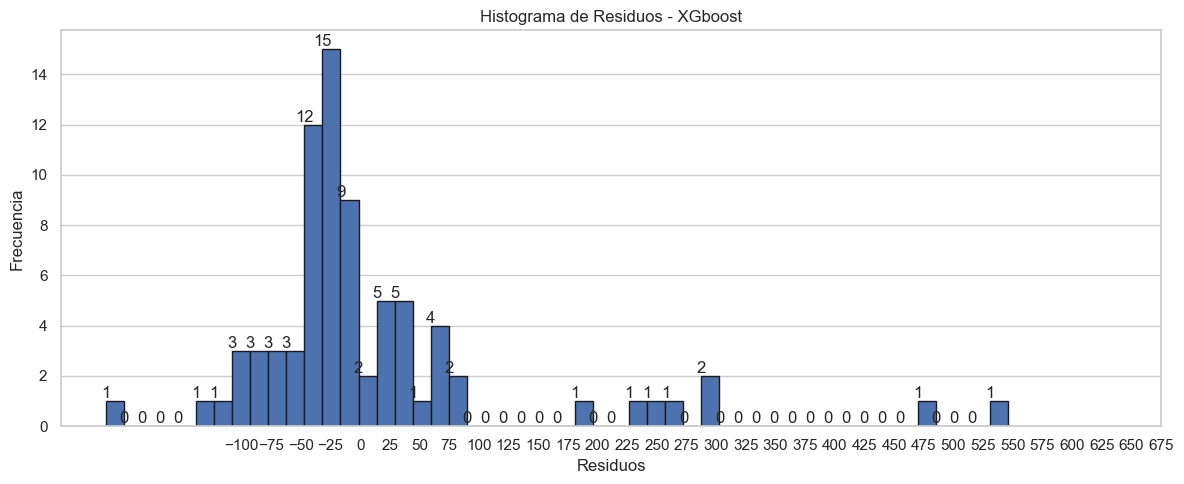

In [82]:
## Verificando nuestros residuos en intervalos menores para ver su distribución
plt.figure(figsize=(12, 5))

xbg_residuals = y_test - xbg_predictions

# Graficar el histograma de los residuos
hist, bins, _ = plt.hist(xbg_residuals[(xbg_residuals != 0) & ((xbg_residuals < -10) | (xbg_residuals > 10))], bins=50, edgecolor='k')

plt.title('Histograma de Residuos - XGboost')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
# plt.xlim(-120, 120)
# plt.ylim(0, 50)

# Colocar las frecuencias en la gráfica
for i in range(len(hist)):
    plt.text(bins[i], hist[i], str(int(hist[i])), ha='center', va='bottom')
    
# # Ajustar la ubicación de los ticks del eje x
plt.xticks(np.arange(-100, 700, 25))
plt.grid(axis='x')
plt.tight_layout()    
plt.show()

**PRECISIÓN EN EL MODELO - VALORES DISTINTOS DE CERO**

In [83]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

# Supongamos que 'y_test' son tus valores reales y 'y_pred' son las predicciones de tu modelo

# Binarización de los datos de prueba
y_test_binary = (y_test > 0).astype(int)
y_pred_binary = (xbg_predictions > 0).astype(int)

# Calcular las métricas de clasificación binaria
accuracy = accuracy_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary)
recall = recall_score(y_test_binary, y_pred_binary)
roc_auc = roc_auc_score(y_test_binary, y_pred_binary)

# Imprimir las métricas
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("ROC AUC:", roc_auc)

Accuracy: 0.09090909090909091
Precision: 0.011545293072824156
Recall: 0.78
ROC AUC: 0.4307152682255846


In [84]:
from sklearn.metrics import confusion_matrix

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# Extraer valores de la matriz de confusión
tn, fp, fn, tp = conf_matrix.ravel()

# Calcular métricas adicionales
false_positive_rate = fp / (fp + tn)
false_negative_rate = fn / (fn + tp)

# Imprimir la matriz de confusión y métricas adicionales
print("Matriz de Confusión:")
print(conf_matrix)
print("False Positive Rate:", false_positive_rate)
print("False Negative Rate:", false_negative_rate)

Matriz de Confusión:
[[ 296 3339]
 [  11   39]]
False Positive Rate: 0.9185694635488308
False Negative Rate: 0.22


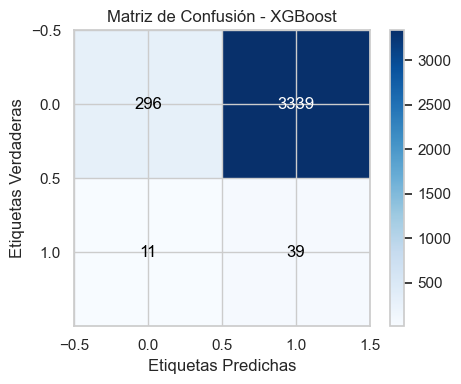

In [85]:
# Configurar la figura
plt.figure(figsize=(5, 4))

# Mostrar la matriz de confusión como una imagen
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)

# Añadir etiquetas de los ejes
plt.title('Matriz de Confusión - XGBoost')
plt.colorbar()
plt.xlabel('Etiquetas Predichas')
plt.ylabel('Etiquetas Verdaderas')

# Añadir números en las celdas
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")
        
plt.yticks(np.arange(-0.5, 1.5, 0.5))

# Mostrar la gráfica
plt.tight_layout()
plt.show()

### 4.2.3 MODELO RANDOM FOREST 

In [86]:
## Definiendo el espacio de búsqueda de Hiperparámetros para el modelo
rf_params = {
    'n_estimators':[int(x) for x in np.linspace(start=100, stop=1000, num=10)],
    'max_features': ['sqrt'],
    'max_depth': [int(x) for x in np.linspace(10,100,num=11)] + [None],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1,2,4],
    'bootstrap': [True,False]
}

## Realizamos la búsqueda aleatoria
random_search = RandomizedSearchCV(RandomForestRegressor(), param_distributions = rf_params,
                                  n_iter=50, cv=5, scoring='r2', random_state=42)
random_search.fit(x_train, y_train)

## Obteniendo el mejor modelo
rf_best_model = random_search.best_estimator_

In [87]:
## Realizando las predicciones
rf_predictions = rf_best_model.predict(x_test)
rf_predictions[rf_predictions<0] = 0

#### 4.2.3.1 MÉTRICAS DEL MODELO 

**R2 - RMSE - MAE**

In [88]:
## Calculando las métricas del modelo
r2_rf = r2_score(y_test, rf_predictions)*100
rmse_rf = np.sqrt(mean_squared_error(y_test, rf_predictions))

from sklearn.metrics import mean_absolute_error
mae_rf = mean_absolute_error(y_test, rf_predictions) 

rf_metrics = []
rf_metrics.extend([r2_rf, rmse_rf, mae_rf])

r2_rf, rmse_rf, mae_rf

(26.033108592534692, 16.804210614808827, 1.5759890440675954)

**VISUALIZACIÓN DE RESIDUOS**

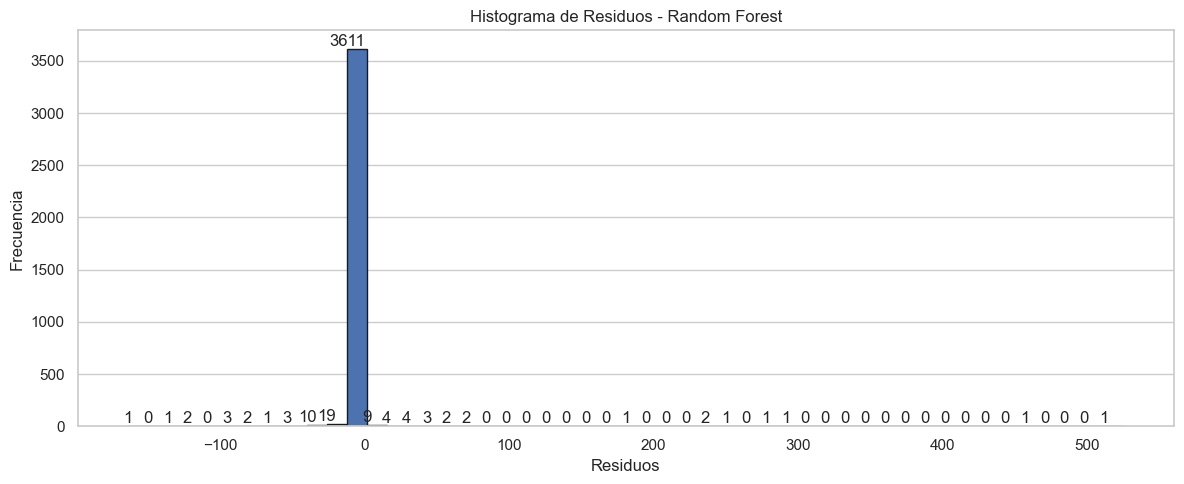

In [89]:
# Visualización de residuos
rf_residuals = y_test - rf_predictions

plt.figure(figsize=(12, 5))

# Graficar el histograma de los residuos
hist, bins, _ = plt.hist(rf_residuals, bins=50, edgecolor='k')

plt.title('Histograma de Residuos - Random Forest')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
# plt.xlim(-120, 120)
# plt.ylim(0, 50)

# Colocar las frecuencias en la gráfica
for i in range(len(hist)):
    plt.text(bins[i], hist[i], str(int(hist[i])), ha='center', va='bottom')
    
# Ajustar la ubicación de los ticks del eje x
# plt.xticks(np.arange(-120, 121, 20))
plt.grid(axis='x')
plt.tight_layout()    
plt.show()

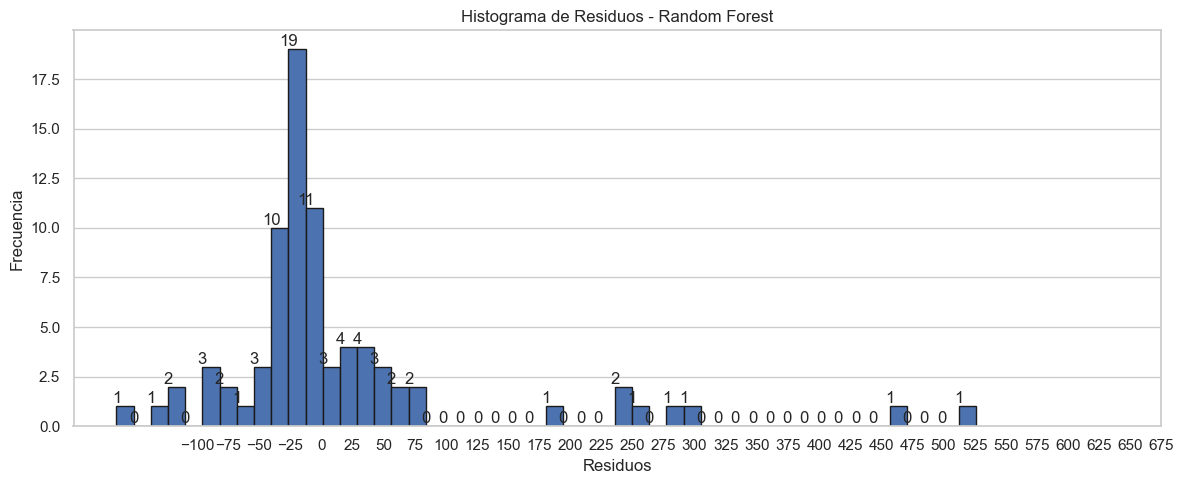

In [90]:
## Verificando nuestros residuos en intervalos menores para ver su distribución
plt.figure(figsize=(12, 5))

rf_residuals = y_test - rf_predictions

# Graficar el histograma de los residuos
hist, bins, _ = plt.hist(rf_residuals[(rf_residuals != 0) & ((rf_residuals < -10) | (rf_residuals > 10))], bins=50, edgecolor='k')

plt.title('Histograma de Residuos - Random Forest')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
# plt.xlim(-120, 120)
# plt.ylim(0, 50)

# Colocar las frecuencias en la gráfica
for i in range(len(hist)):
    plt.text(bins[i], hist[i], str(int(hist[i])), ha='center', va='bottom')
    
# # Ajustar la ubicación de los ticks del eje x
plt.xticks(np.arange(-100, 700, 25))
plt.grid(axis='x')
plt.tight_layout()    
plt.show()

**PRECISIÓN EN EL MODELO - VALORES DISTINTOS DE CERO**

In [91]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

# Supongamos que 'y_test' son tus valores reales y 'y_pred' son las predicciones de tu modelo

# Binarización de los datos de prueba
y_test_binary = (y_test > 0).astype(int)
y_pred_binary = (rf_predictions > 0).astype(int)

# Calcular las métricas de clasificación binaria
accuracy = accuracy_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary)
recall = recall_score(y_test_binary, y_pred_binary)
roc_auc = roc_auc_score(y_test_binary, y_pred_binary)

# Imprimir las métricas
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("ROC AUC:", roc_auc)

Accuracy: 0.8529172320217097
Precision: 0.08445945945945946
Recall: 1.0
ROC AUC: 0.9254470426409904


In [92]:
from sklearn.metrics import confusion_matrix

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# Extraer valores de la matriz de confusión
tn, fp, fn, tp = conf_matrix.ravel()

# Calcular métricas adicionales
false_positive_rate = fp / (fp + tn)
false_negative_rate = fn / (fn + tp)

# Imprimir la matriz de confusión y métricas adicionales
print("Matriz de Confusión:")
print(conf_matrix)
print("False Positive Rate:", false_positive_rate)
print("False Negative Rate:", false_negative_rate)

Matriz de Confusión:
[[3093  542]
 [   0   50]]
False Positive Rate: 0.14910591471801926
False Negative Rate: 0.0


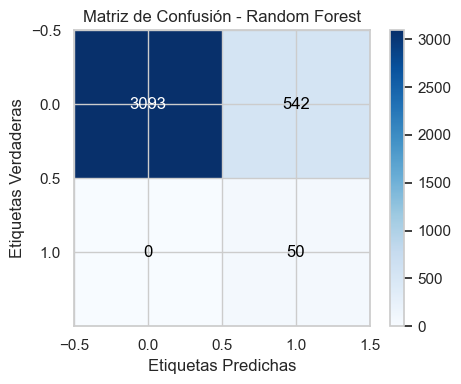

In [93]:
# Configurar la figura
plt.figure(figsize=(5, 4))

# Mostrar la matriz de confusión como una imagen
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)

# Añadir etiquetas de los ejes
plt.title('Matriz de Confusión - Random Forest')
plt.colorbar()
plt.xlabel('Etiquetas Predichas')
plt.ylabel('Etiquetas Verdaderas')

# Añadir números en las celdas
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")
        
plt.yticks(np.arange(-0.5, 1.5, 0.5))

# Mostrar la gráfica
plt.tight_layout()
plt.show()

### 4.2.4 MODELO REGRESIÓN LINEAL

In [94]:
# Entrenando el modelo
model_linear = LinearRegression()
model_linear.fit(x_train,y_train)

LinearRegression()

In [95]:
## Realizando las predicciones
linear_predictions = model_linear.predict(x_test)
linear_predictions[linear_predictions<0] = 0

**4.2.4.1 MÉTRICAS DEL MODELO**

**R2 - RMSE - MAE**

In [96]:
from sklearn.metrics import mean_absolute_error

## Calculando las métricas del modelo
r2_linear = r2_score(y_test, linear_predictions)*100
rmse_linear = np.sqrt(mean_squared_error(y_test, linear_predictions))
mae_linear = mean_absolute_error(y_test, linear_predictions) 

linear_metrics = []
linear_metrics.extend([r2_linear, rmse_linear, mae_linear])

r2_linear, rmse_linear, mae_linear

(18.525383468424895, 17.63642659488049, 1.7302195010350427)

**PRECISIÓN EN EL MODELO - VALORES DISTINTOS DE CERO**

In [97]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

# Supongamos que 'y_test' son tus valores reales y 'y_pred' son las predicciones de tu modelo

# Binarización de los datos de prueba
y_test_binary = (y_test > 0).astype(int)
y_pred_binary = (linear_predictions > 0).astype(int)

# Calcular las métricas de clasificación binaria
accuracy = accuracy_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary)
recall = recall_score(y_test_binary, y_pred_binary)
roc_auc = roc_auc_score(y_test_binary, y_pred_binary)

# Imprimir las métricas
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("ROC AUC:", roc_auc)

Accuracy: 0.5793758480325645
Precision: 0.02531645569620253
Recall: 0.8
ROC AUC: 0.6881705639614856


In [98]:
from sklearn.metrics import confusion_matrix

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# Extraer valores de la matriz de confusión
tn, fp, fn, tp = conf_matrix.ravel()

# Calcular métricas adicionales
false_positive_rate = fp / (fp + tn)
false_negative_rate = fn / (fn + tp)

# Imprimir la matriz de confusión y métricas adicionales
print("Matriz de Confusión:")
print(conf_matrix)
print("False Positive Rate:", false_positive_rate)
print("False Negative Rate:", false_negative_rate)

Matriz de Confusión:
[[2095 1540]
 [  10   40]]
False Positive Rate: 0.4236588720770289
False Negative Rate: 0.2


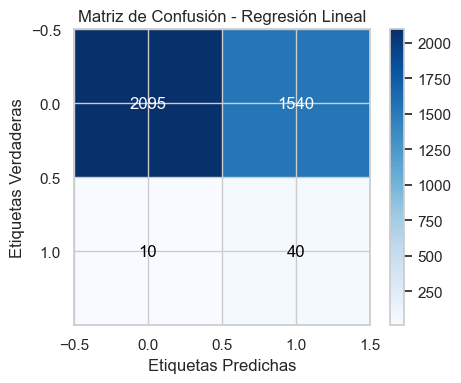

In [99]:
# Configurar la figura
plt.figure(figsize=(5, 4))

# Mostrar la matriz de confusión como una imagen
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)

# Añadir etiquetas de los ejes
plt.title('Matriz de Confusión - Regresión Lineal')
plt.colorbar()
plt.xlabel('Etiquetas Predichas')
plt.ylabel('Etiquetas Verdaderas')

# Añadir números en las celdas
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")
        
plt.yticks(np.arange(-0.5, 1.5, 0.5))

# Mostrar la gráfica
plt.tight_layout()
plt.show()

**VISUALIZACIÓN DE RESIDUOS**

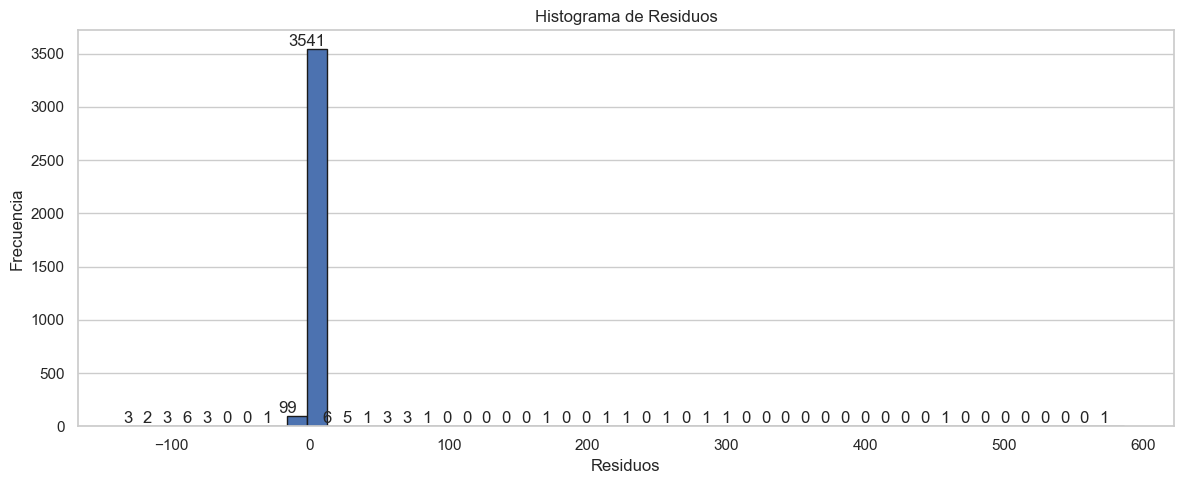

In [100]:
# Visualización de residuos
linear_residuals = y_test - linear_predictions

plt.figure(figsize=(12, 5))

# Graficar el histograma de los residuos
hist, bins, _ = plt.hist(linear_residuals, bins=50, edgecolor='k')

plt.title('Histograma de Residuos')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
# plt.xlim(-120, 120)
# plt.ylim(0, 50)

# Colocar las frecuencias en la gráfica
for i in range(len(hist)):
    plt.text(bins[i], hist[i], str(int(hist[i])), ha='center', va='bottom')
    
# Ajustar la ubicación de los ticks del eje x
# plt.xticks(np.arange(-120, 121, 20))
plt.grid(axis='x')
plt.tight_layout()    
plt.show()

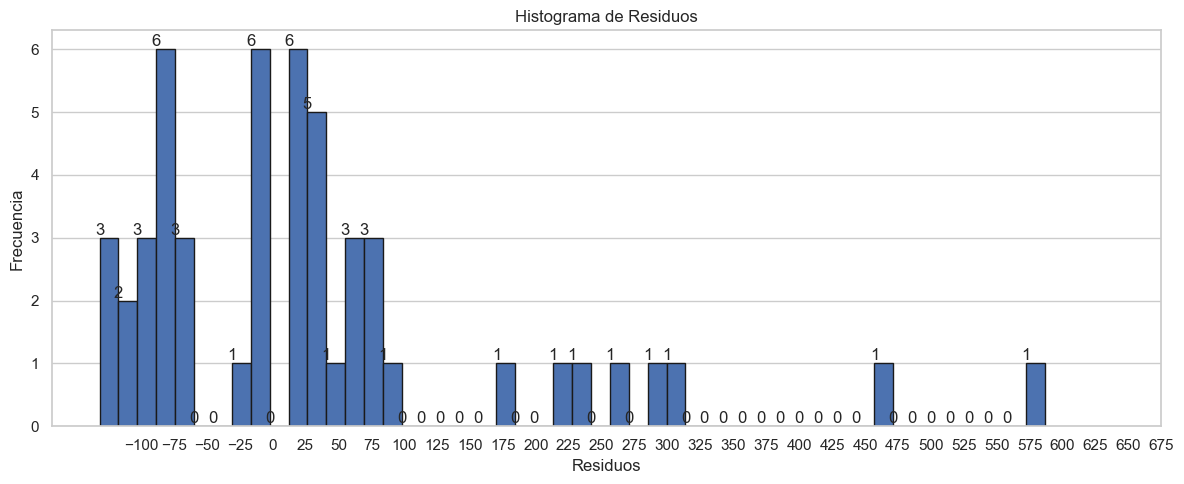

In [101]:
## Verificando nuestros residuos en intervalos menores para ver su distribución
plt.figure(figsize=(12, 5))

linear_residuals = y_test - linear_predictions

# Graficar el histograma de los residuos
hist, bins, _ = plt.hist(linear_residuals[(linear_residuals != 0) & ((linear_residuals < -10) | (linear_residuals > 10))], bins=50, edgecolor='k')

plt.title('Histograma de Residuos')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
# plt.xlim(-120, 120)
# plt.ylim(0, 50)

# Colocar las frecuencias en la gráfica
for i in range(len(hist)):
    plt.text(bins[i], hist[i], str(int(hist[i])), ha='center', va='bottom')
    
# # Ajustar la ubicación de los ticks del eje x
plt.xticks(np.arange(-100, 700, 25))
plt.grid(axis='x')
plt.tight_layout()    
plt.show()

## 5. EVALUACIÓN Y SELECCIÓN DEL MODELO

In [102]:
modelos = ['LGBoost', 'XGBoost', 'Random Forest', 'Linear Regression']
metricas = ['R2', 'RMSE', 'MAE']

In [103]:
## Creando el cuadro comparativo de métricas para nuestros modelos evaluados
comparativo_metricas = pd.DataFrame({
    'Métricas': metricas,
     modelos[0]: lgb_metrics,
     modelos[1]: xgb_metrics,
     modelos[2]: rf_metrics,
     modelos[3]: linear_metrics
})
comparativo_metricas.style.background_gradient()

,Métricas,LGBoost,XGBoost,Random Forest,Linear Regression
0,R2,19.967770,19.678410,26.033109,18.525383
1,RMSE,17.479616,17.511187,16.804211,17.636427
2,MAE,1.594831,1.640601,1.575989,1.730220


In [104]:
## Cambiamos de un formato ancho a uno largo para poder graficar de mejor manera nuestros datos
comparativo_metricas.melt(id_vars='Métricas').style.background_gradient()

,Métricas,variable,value
0,R2,LGBoost,19.967770
1,RMSE,LGBoost,17.479616
2,MAE,LGBoost,1.594831
3,R2,XGBoost,19.678410
4,RMSE,XGBoost,17.511187
5,MAE,XGBoost,1.640601
6,R2,Random Forest,26.033109
7,RMSE,Random Forest,16.804211
8,MAE,Random Forest,1.575989
9,R2,Linear Regression,18.525383


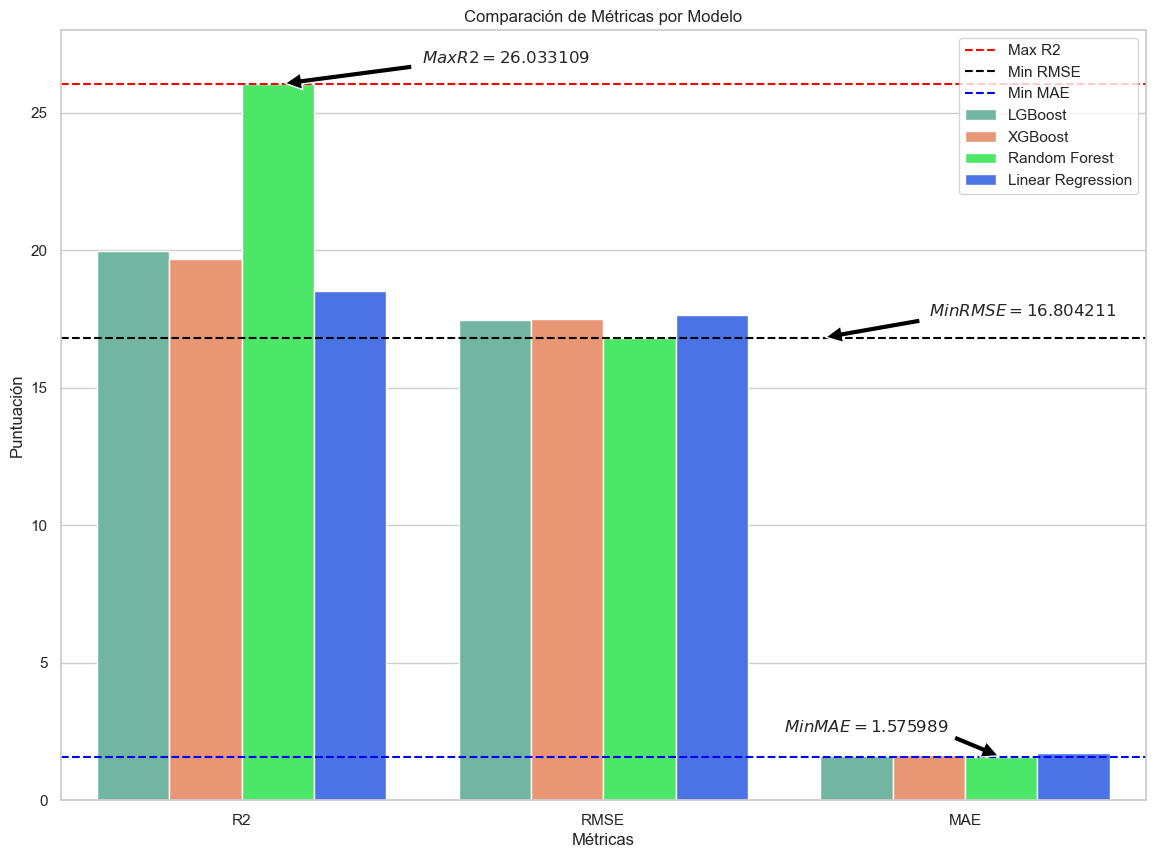

In [118]:
## Graficando la comparación de métricas entre nuestros modelos evaluados
plt.figure(figsize=(14, 10))
colors = ['#66c2a5', '#fc8d62',"#33FF57", "#3366FF"]
sns.barplot(data=comparativo_metricas.melt(id_vars='Métricas'), x='Métricas', y='value', hue='variable', palette=colors)
plt.xlabel('Métricas')
plt.ylabel('Puntuación')
ax = plt.gca()  # Obtiene el objeto de los ejes
ax.set_ylim(bottom=0, top=28)
plt.axhline(y=26.033109, color='red', linestyle='--', label='Max R2')
plt.axhline(y=16.804211, color='black', linestyle='--', label='Min RMSE')
plt.axhline(y=1.575989, color='blue', linestyle='--', label='Min MAE')
plt.annotate('$Max R2 = 26.033109$', xy=(0.1, 26.033109), xytext=(0.5, 26.033109+0.8),fontsize=12,
                                        arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('$Min RMSE = 16.804211$', xy=(1.6, 16.804211), xytext=(1.9, 16.804211+0.8),fontsize=12,
                                        arrowprops=dict(facecolor='black', shrink=0.05))
# plt.annotate('$Min MAE = 2.383354$', xy=(0.5, 2.383354), xytext=(2.3, 2.383354+0.01),fontsize=12)
plt.annotate('$Min MAE = 1.575989$', xy=(2.1, 1.575989), xytext=(1.5, 1.575989+0.9),fontsize=12, 
                                        arrowprops=dict(facecolor='black', shrink=0.05)) 
plt.title('Comparación de Métricas por Modelo')
plt.legend();

## 6. PRODUCCIÓN

In [122]:
## Creamos una copia del dataframe preprocesado
df_traffic_production = df_traffic_new.copy()

In [123]:
## Separamos nuestra data en conjunto de datos X y Y
x = df_traffic_production.drop(columns='transactionRevenue')
y = df_traffic_production['transactionRevenue']

## Estandarizamos nuestros datos
scaled = StandardScaler()
x_scaled_before = scaled.fit_transform(x)

x['classification'] = model_classification.predict(x_scaled_before)

## Estandarizamos nuevamente nuestro conjunto de datos X
scaled = StandardScaler()
x_scaled_after = scaled.fit_transform(x)

In [124]:
## Realizando las predicciones
real_predictions = rf_best_model.predict(x_scaled_after)
real_predictions[real_predictions<1] = 0

In [131]:
#Ejemplos de los pronósticos
df_resultados = pd.DataFrame({
    'transactionRevenue': y,
    'predictions': real_predictions
})
df_resultados[df_resultados.transactionRevenue>0].sample(12)

,transactionRevenue,predictions
11154,17.98,44.977159
2599,37.80,51.424945
448,55.96,86.949956
4410,14.48,1.411975
2168,39.68,77.835117
2838,18.99,47.411696
280,27.19,49.326383
7563,45.57,61.930408
10714,197.70,127.494114
4321,95.18,100.517935


**VISUALIZCIÓN DE RESIDUOS - PREDICCIÓN REAL**

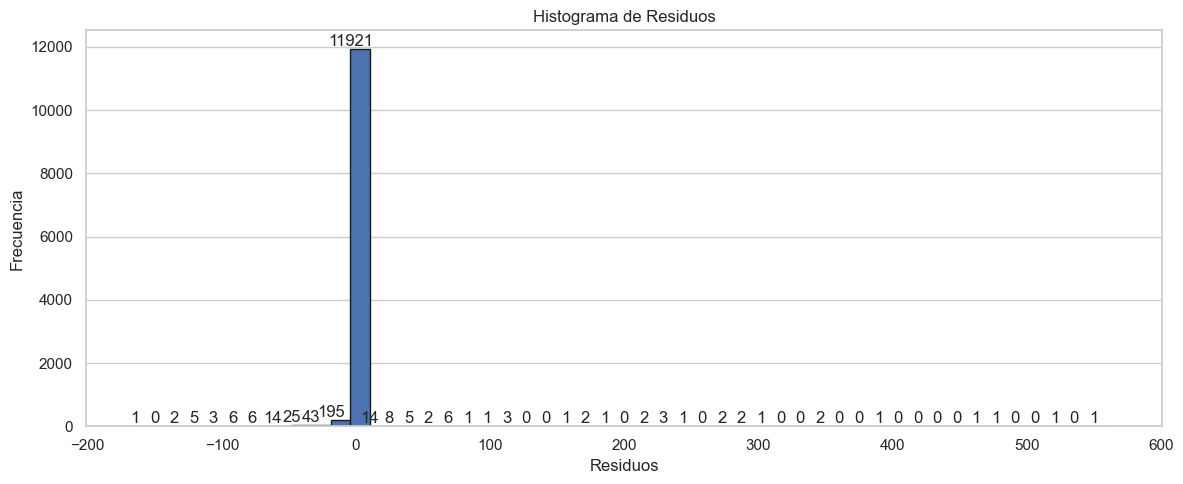

In [132]:
# Visualización de residuos
residuals = y - real_predictions

plt.figure(figsize=(12, 5))

# Graficar el histograma de los residuos
hist, bins, _ = plt.hist(residuals, bins=50, edgecolor='k')

plt.title('Histograma de Residuos')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
# plt.xlim(-120, 120)
# plt.ylim(0, 50)

# Colocar las frecuencias en la gráfica
for i in range(len(hist)):
    plt.text(bins[i], hist[i], str(int(hist[i])), ha='center', va='bottom')
    
# Ajustar la ubicación de los ticks del eje x
# plt.xticks(np.arange(-120, 121, 20))
plt.grid(axis='x')
plt.tight_layout()    
plt.show()

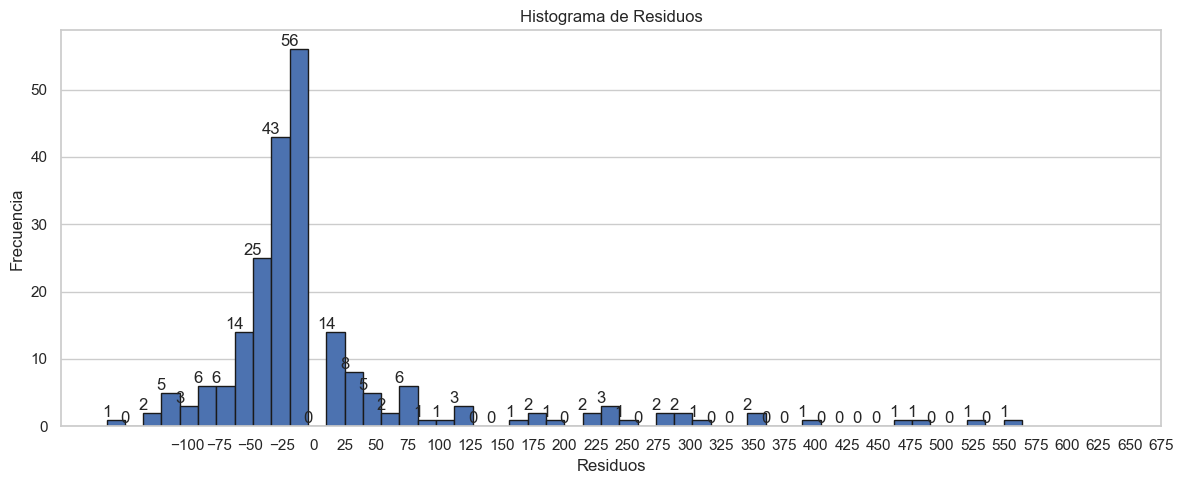

In [133]:
## Verificando nuestros residuos en intervalos menores para ver su distribución
plt.figure(figsize=(12, 5))

residuals = y - real_predictions

# Graficar el histograma de los residuos
hist, bins, _ = plt.hist(residuals[(residuals != 0) & ((residuals < -10) | (residuals > 10))], bins=50, edgecolor='k')

plt.title('Histograma de Residuos')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
# plt.xlim(-120, 120)
# plt.ylim(0, 50)

# Colocar las frecuencias en la gráfica
for i in range(len(hist)):
    plt.text(bins[i], hist[i], str(int(hist[i])), ha='center', va='bottom')
    
# # Ajustar la ubicación de los ticks del eje x
plt.xticks(np.arange(-100, 700, 25))
plt.grid(axis='x')
plt.tight_layout()    
plt.show()

**PRECISIÓN DE LA PREDICCIÓN REAL - BINARIZACIÓN**

In [134]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

# 'y' son tus valores reales y 'real_predictions' son las predicciones del modelo

# Binarización de los datos de prueba
y_test_binary = (y > 0).astype(int)
y_pred_binary = (real_predictions > 0).astype(int)

# Calcular las métricas de clasificación binaria
accuracy = accuracy_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary)
recall = recall_score(y_test_binary, y_pred_binary)
roc_auc = roc_auc_score(y_test_binary, y_pred_binary)

# Imprimir las métricas
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("ROC AUC:", roc_auc)

Accuracy: 0.9519661320524302
Precision: 0.21216216216216216
Recall: 0.9573170731707317
ROC AUC: 0.9546053968873709


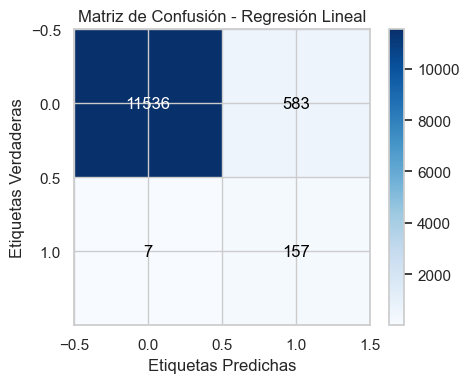

In [135]:
# Configurar la figura
plt.figure(figsize=(5, 4))

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# Mostrar la matriz de confusión como una imagen
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)

# Añadir etiquetas de los ejes
plt.title('Matriz de Confusión - Regresión Lineal')
plt.colorbar()
plt.xlabel('Etiquetas Predichas')
plt.ylabel('Etiquetas Verdaderas')

# Añadir números en las celdas
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")
        
plt.yticks(np.arange(-0.5, 1.5, 0.5))

# Mostrar la gráfica
plt.tight_layout()
plt.show()

## 7. CONCLUSIONES

* Construimos 4 modelos de regresión con la finalidad de predecir las personas que generan compras luego de visitar una página web **(LGBoost, XGBosst, Random Forest y Linear Regression)**


* Las principales métricas analizadas para los modelos fueron el **R2, RMSE y MAE**. Luego de analizar estas métricas, concluimos que el **R2** no es tan relevante ya que poseemos casi todos los valores de transacciones en cero, y al estar muy dirigido para un lado, este valor no nos aporta lo necesario como para determinar una variabilidad como tal. Por el contrario el **RMSE y MAE**, los consideramos de mucha valía, ya que al representarnos la diferencia de los valores reales y predichos, al conseguir menores valores de estos, nos acercaríamos a valores más certeros.


* Si solo nos enfocaramos en estas dos métricas, de acuerdo a nuestro gráfico de comparativo de Métricas, El modelo que consiguió menores valores fue el **Random Forest**.


* Sin embargo, no quisimos quedarnos solo con estos dos parámetros, es por eso que decidimos realizar una **Visualización de los Residuos**. Luego de observar los residuos, notamos en los histogramas que si bien muchos valores estan cerca al cero, indicandonos que los valores predichos y reales, no tienen tanta diferencia, tambien hay varios valores que nos indican una gran diferencia en los pronósticos. Es asi, que despues de analizar estos residuos, deducimos que el **Random Forest y XGBosst**, son los que consiguieron mejores respuestas en diferencias de residuos.


* El último análisis que realizamos **fue la Predicción de resultados - Valores diferentes de cero**. Para esto hicimos uso de la **Binarización de los valores reales y predichos**, de esta forma conseguimos realizar una clasificación Binaria donde pudimos hallar los valores de **Accuracy, recall, AUC, entre otros**, los cuales nos ayudan a entender también como se esta generando el modelo. Es así que notamos que ningún modelo tiene excelentes resultados, sin embargo, el modelo que nos aporta un valor predicho y un valor real más exacto, por lo menos en la **clase 0** (Es cuando se tiene valor cero de consumo), es el **Random Forest**. Si bien, presenta errores para predecir los valores de la **clase 1**, es el que menor falso negativo y positivo posee de todos los modelos analizados, asimismo es el que obtuvo mejor **accuracy** de entre todos.


* Para finalizar, Luego de realizar multiples análisis, nos decantamos por el Modelo **Random Forest**, el cual nos demuestra que consiguió los mejores resultados.


* Cuando llevamos a producción nuestro modelo de **Random Forest**, notamos que efectivamente los resultados predichos de los reales no tienen una diferencia muy grande (Visualización de residuos). Si existe algunos pronosticos que escapan de esto, pero en general se comporta de buena manera.


* Sin embargo, si bien la precisión del modelo es buena, notamos en nuestra matriz de confusión de los datos reales, que aún tenemos dificultades para bajar los falsos positivos del modelo, por lo menos para nuestra **clase 1**, que es cuando detecta el modelo que hay consumo. Esto principalmente debido al alto grado de desbalance del modelo. Cabe precisar, que esto podríamos mejorarlo si tuvieramos muchos más datos de la **clase 1**, ya que esto para bien o para mal, nos genera un sesgo en el modelo.